# 计算机网络体系结构第一次作业

作业要求：

> 请以一段时间内的真实指数基金行情数据，
>
> 1）验证定期等额平均成本投资法。例如：投资周期可以是日、周、月、季度、年，投资粒度 5000 元人民币，手续费参照代码 1“获取行情数据程序”中的 buy, sell 注释部分。
>
> 2）给出较优的投资周期、ETF 基金标的等参数，及理由。
>
> 3）验证附录 A 中的 14.1 资产配置原则之一：重新调整投资组合内资产类别的权重可以降低风险，在某些情况下，还可以提高投资收益。
>
> 注：行情数据可以通过 AKSahre 接口获得，https://akshare.akfamily.xyz

## 实验设置

买卖的最小单位是一手，即 100 份。

考虑印花税、过户费、佣金等交易费用。

进行投资的时间段为 2017 年 9 月 1 日到 2024 年 3 月 14 日。为了分析的需要，可能会使用在该时间段之前的部分数据。

### 买入

若忽略起点，买入费率为 0.038%

- 考虑买入证券交易费：过户费、佣金
- 过户费：按成交证券的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = deltaPosition * stockToday["收盘"]
costBuy = deltaPositionValue*0.02/1e3 + max(deltaPositionValue*0.018/100, 5)
#self.cash -= deltaPosition * stockToday["收盘"]
self.cash = self.cash - deltaPositionValue - costBuy

#没有考虑self.cash不够，出现负数的情况
```

### 卖出

若忽略起点，买入费率为 0.043%

- 考虑买入证券交易费：印花税、过户费、佣金
- 印花税：单向收取，卖出成交金额的万分之五（5‱）印花税由政府收取
- 过户费：按成交证券的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = pos["头寸"] * stockToday["收盘"]
costSell = deltaPositionValue*(1e-3 + 0.02/1e3) + max(deltaPositionValue*0.018/100, 5)
```

### 选取的标的

股票基金：

- 房地产 ETF
- 中概互联网 ETF
- 沪深 300 ETF
- 上证 50 ETF
- 中证 500 ETF
- 创业板 ETF
- 中小 100ETF
- 医药 ETF
- 证券 ETF
- 环保 ETF
- 恒生 ETF
- H 股 ETF
- 标普 500 ETF
- 纳指 ETF
- 军工 ETF
- 银行 ETF
- 传媒 ETF

债券基金：

- 国债 ETF
- 十年国债 ETF

### 交易周期

选取的交易周期：

- 1 天，对应一日。
- 3 天，对应半周。
- 7 天，对应一周。
- 15 天，对应半月。
- 30 天，对应月。
- 90 天，对应季度。
- 180 天，对应半年。
- 365 天，对应年。
- 3000 天，对应一次性买入。

_注：由于 `datetime` 库的 `timedelta` 只支持日或者周等确定长度的时间段，此处全部以日数为单位。_

### 资金投入

按照每期 5000 元的粒度进行投入。


## 实验代码及说明


### 准备依赖


In [204]:
# !python -m pip install akshare joblib matplotlib numpy pandas PyPortfolioOpt scipy

In [205]:
import akshare as ak
import calendar
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import mpl
import os

# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False

### 准备实验数据


In [206]:
stockNameCodes: list[tuple[str, str]] = [
    ("512200", "房地产ETF"),
    ("513050", "中概互联网ETF"),
    ("510300", "沪深300ETF"),
    ("510050", "上证50ETF"),
    ("510500", "中证500ETF"),
    ("159915", "创业板ETF"),
    ("159902", "中小100ETF"),
    ("512010", "医药ETF"),
    ("512880", "证券ETF"),
    ("512580", "环保ETF"),
    ("159920", "恒生ETF"),
    ("510900", "H股ETF"),
    ("513500", "标普500ETF"),
    ("513100", "纳指ETF"),
    ("512660", "军工ETF"),
    ("512800", "银行ETF"),
    # ("512400", "有色ETF"),
    ("512980", "传媒ETF"),
    ("511010", "国债ETF"),
    ("511260", "十年国债ETF"),
]


def Preprocess(startDate: datetime.datetime, endDate: datetime.datetime):
    # 获取标的历史数据
    startDate = startDate - datetime.timedelta(days=365)

    allStockDaily: dict[str, pd.DataFrame] = {}
    path = f'data/{startDate.strftime("%Y")}-{endDate.strftime("%Y")}'
    if os.path.exists(path):
        print(f'使用已有数据({startDate.strftime("%Y")}-{endDate.strftime("%Y")})')
        for code, name in stockNameCodes:
            try:
                stockDaily = pd.read_csv(os.path.join(
                    path, f"{name}_{code}.csv"), sep=',')
                stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])
                stockDaily = stockDaily.set_index("日期", drop=False)

                allStockDaily[code] = stockDaily
            except:
                print(f'{name}({code})读取失败!')
                continue
        return allStockDaily

    os.makedirs(path)
    for i, (code, name) in enumerate(stockNameCodes):
        print(f"{i}. {name}({code}) 正在读取数据...")
        try:
            # stockDaily = ak.stock_zh_a_hist(
            stockDaily = ak.fund_etf_hist_em(
                symbol=code,
                period="daily",
                start_date=startDate.strftime("%Y%m%d"),
                end_date=endDate.strftime("%Y%m%d"),
                adjust="hfq",
            )
        except:
            print(
                f'{name}({code}): {startDate.strftime("%Y-%m-%d")}--{endDate.strftime("%Y-%m-%d")}读取失败!'
            )
            continue
        try:
            # print(stockDaily.columns)
            stockDaily = stockDaily[stockDaily["开盘"].notnull()]
            stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])

            stockDaily.to_csv(os.path.join(
                path, f"{name}_{code}.csv"), index=False)
            stockDaily = stockDaily.set_index("日期", drop=False)

            allStockDaily[code] = stockDaily
        except:
            print(
                f'{name}({code}): {startDate.strftime("%Y-%m-%d")}--{endDate.strftime("%Y-%m-%d")}处理失败!'
            )
            continue
    return allStockDaily


start = datetime.datetime(2017, 9, 1)
end = datetime.datetime(2024, 3, 14)
print(f"{start.strftime('%Y-%m-%d')}到{end.strftime('%Y-%m-%d')}共计 {(end-start).days} 天")
allStockDaily = Preprocess(start, end)
print(f"共有{len(allStockDaily)}个标的数据")

2017-09-01到2024-03-14共计 2386 天
使用已有数据(2016-2024)
共有19个标的数据


房地产ETF     中概互联网ETF     沪深300ETF      上证50ETF     中证500ETF  \
count  1569.000000  1737.000000  1828.000000  1828.000000  1828.000000   
mean      0.796645     1.359805     4.447552     3.318674     1.828117   
std       0.121172     0.356065     0.645451     0.412538     0.240729   
min       0.441000     0.816000     3.285000     2.510000     1.205000   
25%       0.732000     1.076000     4.008750     3.042000     1.678750   
50%       0.802000     1.270000     4.342000     3.284000     1.869000   
75%       0.872000     1.516000     4.781000     3.511000     1.986000   
max       1.143000     2.570000     6.268000     4.557000     2.406000   

            创业板ETF     中小100ETF        医药ETF        证券ETF        环保ETF  \
count  1827.000000  1828.000000  1826.000000  1828.000000  1713.000000   
mean      2.100808     3.756455     1.958442     0.983706     1.106689   
std       0.561124     0.686441     0.523908     0.128198     0.341478   
min       1.153000     2.362000     1.243000     0.623000     0.603000   
25%       1.678000     3.242000     1.598000     0.902000     0.826000   
50%       1.967000     3.675500     1.826000     0.972500     1.009000   
75%       2.512500     4.301000     2.128000     1.061250     1.333000   
max       3.455000     5.462000     3.560000     1.360000     1.956000   

             恒生ETF        H股ETF     标普500ETF        纳指ETF        军工ETF  \
count  1828.000000  1828.000000  1827.000000  1827.000000  1828.000000   
mean      1.389399     1.086454     2.185201     3.623360     0.971125   
std       0.177470     0.179279     0.531707     1.293055     0.193763   
min       0.938000     0.673000     1.401000     1.661000     0.606000   
25%       1.227000     0.894000     1.683500     2.380500     0.810000   
50%       1.432000     1.163000     2.115000     3.796000     0.992000   
75%       1.547000     1.232000     2.627000     4.570000     1.111250   
max       1.712000     1.439000     3.600000     6.695000     1.476000   

             银行ETF        传媒ETF  
count  1606.000000  1491.000000  
mean      1.073998     0.781412  
std       0.086329     0.121842  
min       0.856000     0.506000  
25%       1.016250     0.692000  
50%       1.074000     0.776000  
75%       1.128000     0.867000  
max       1.305000     1.078000

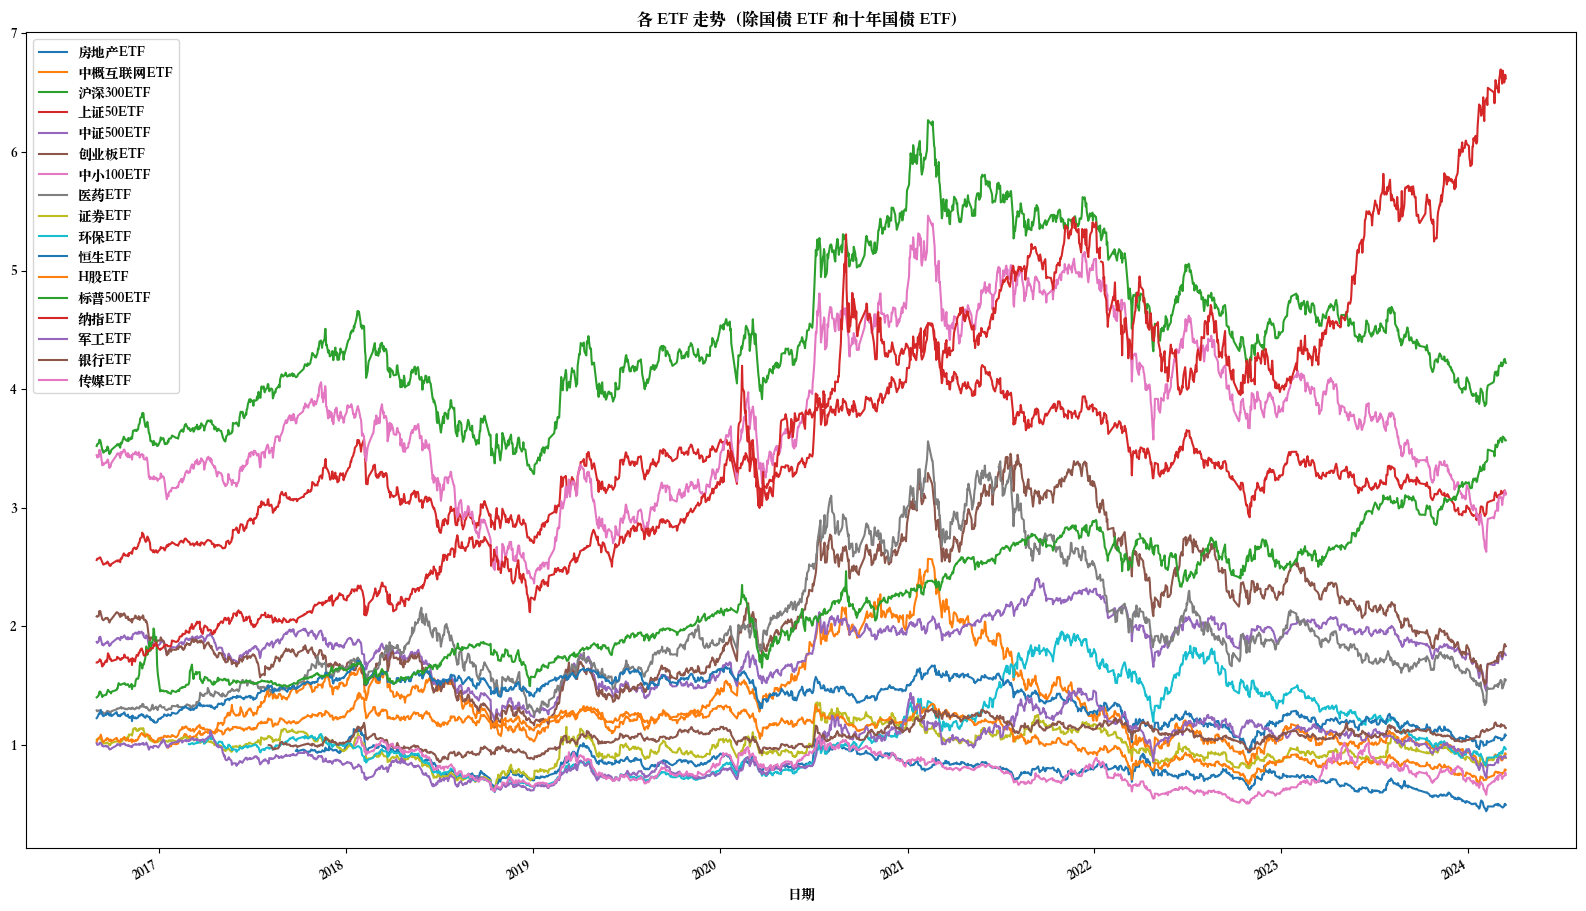

In [207]:
# 基金单价走势
df_prices: pd.DataFrame = pd.DataFrame.from_dict(
    {name: allStockDaily[code].iloc[:, 2] for code,
        name in stockNameCodes if code not in ["511010", "511260"]}
)
df_prices.plot(figsize=(20, 12), title='各 ETF 走势（除国债 ETF 和十年国债 ETF）')
df_prices.describe()

国债ETF      十年国债ETF
count  1828.000000  1590.000000
mean    121.906271   111.755842
std       7.571428     7.620929
min     109.465000    97.050000
25%     114.534250   106.264500
50%     122.419500   111.302500
75%     128.791000   118.175250
max     136.126000   127.161000

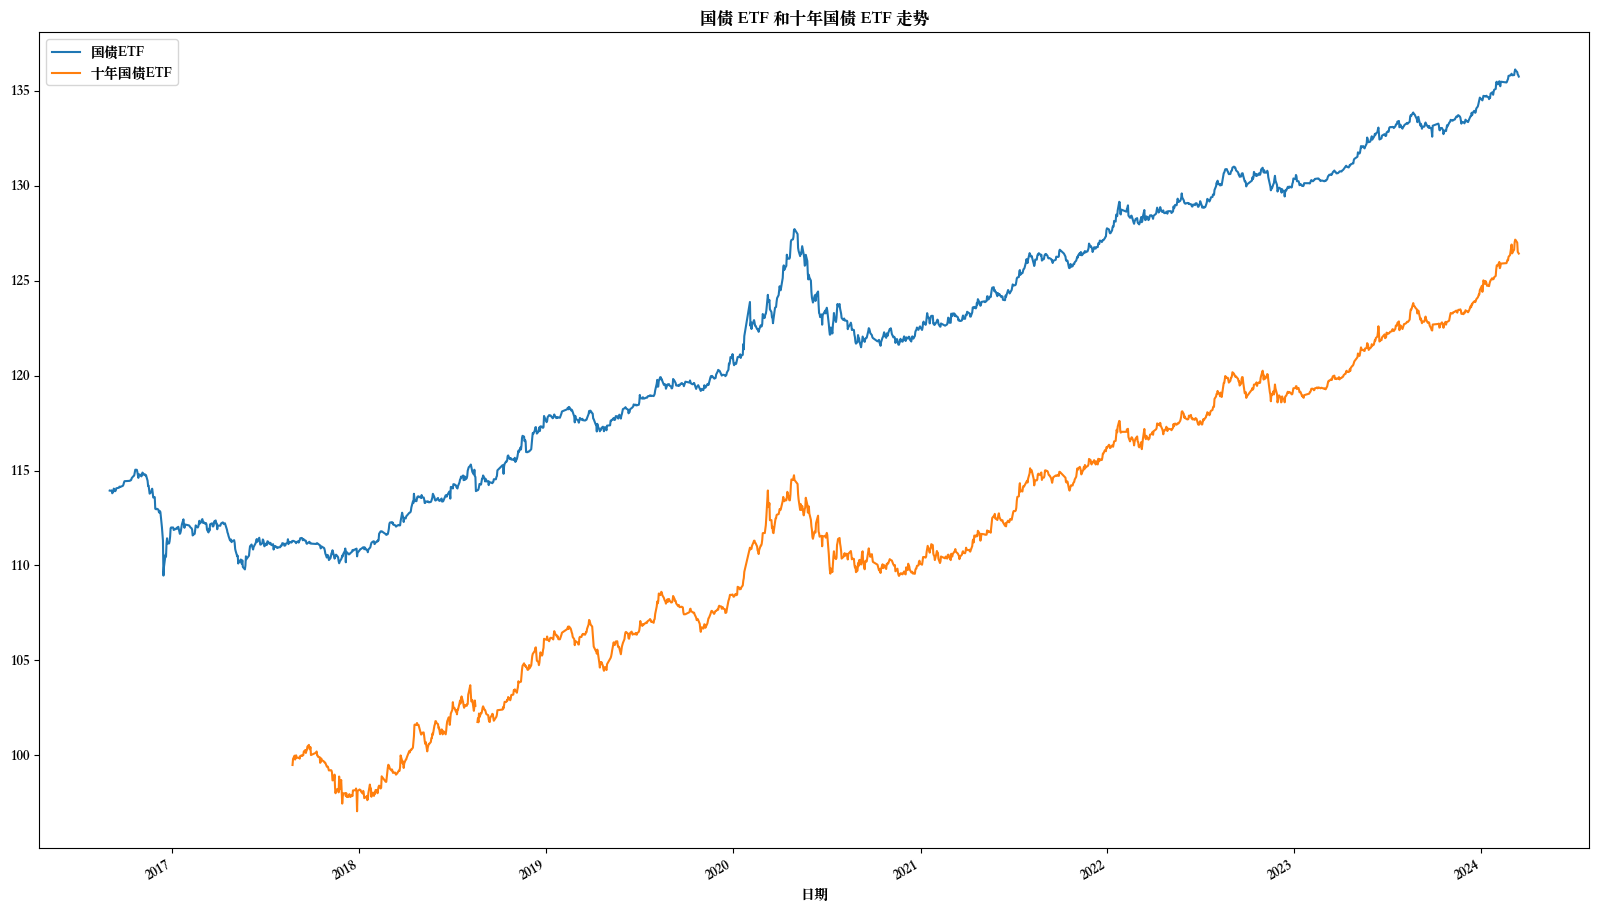

In [208]:
# 基金单价走势
df_prices: pd.DataFrame = pd.DataFrame.from_dict(
    {name: allStockDaily[code].iloc[:, 2] for code,
        name in stockNameCodes if code in ["511010", "511260"]}
)
df_prices.plot(figsize=(20, 12), title='国债 ETF 和十年国债 ETF 走势')
df_prices.describe()

房地产ETF  中概互联网ETF  沪深300ETF   上证50ETF  中证500ETF    创业板ETF  \
日期                                                                       
2017-09-01       NaN  1.440123  1.167898  1.212974  1.032103  0.852207   
2024-03-14  0.521053  0.945752  1.199148  1.219617  0.940610  0.879079   

            中小100ETF     医药ETF     证券ETF     环保ETF     恒生ETF     H股ETF  \
日期                                                                       
2017-09-01  1.071719  1.136997  1.088123  1.006944  1.212072  1.180312   
2024-03-14  0.903310  1.198142  0.853448  0.957341  0.881729  0.769006   

            标普500ETF     纳指ETF     军工ETF     银行ETF     传媒ETF     国债ETF  \
日期                                                                       
2017-09-01  1.073519  1.220649  0.887463  1.005005       NaN  0.976216   
2024-03-14  2.546752  3.905605  0.881540  1.143143  0.746254  1.191415   

             十年国债ETF  
日期                    
2017-09-01  1.003810  
2024-03-14  1.270799

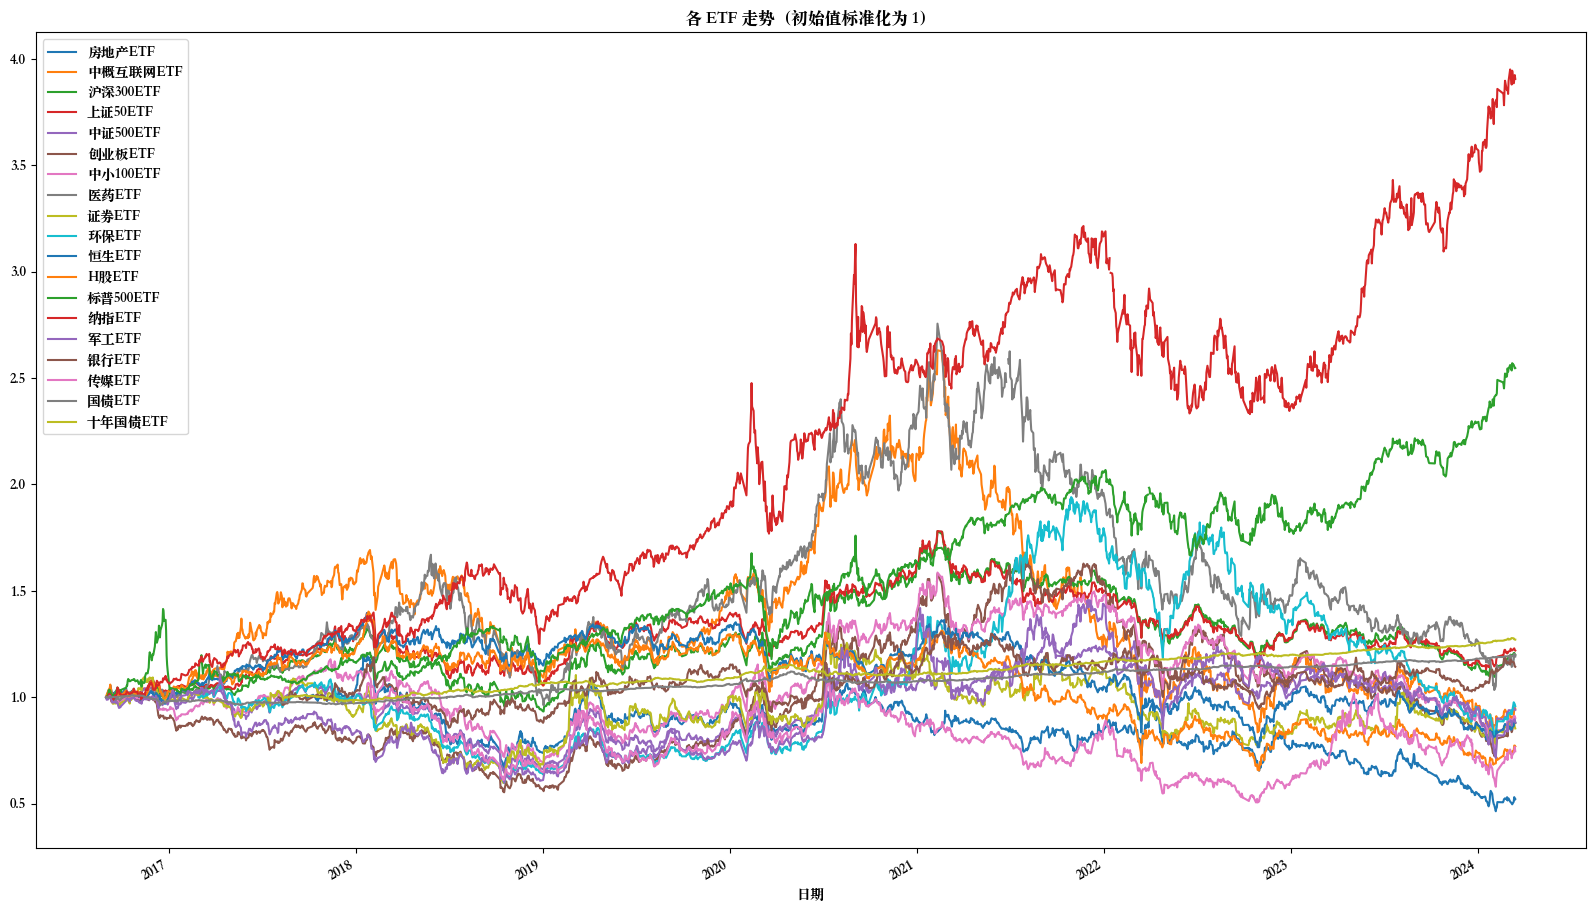

In [209]:
# 基金单价（初始值标准化为 1）走势
prices_normalized: pd.DataFrame = pd.concat([i.iloc[:, 2]/i.iloc[0, 2]
                                             for _, i in allStockDaily.items()], keys=[i[1] for i in stockNameCodes], axis=1)
prices_normalized.to_csv("data/prices_normalized.csv")
prices_normalized.plot(figsize=(20, 12), title='各 ETF 走势（初始值标准化为 1）')
prices_normalized.loc[[start, end]]

In [210]:
class ExtraCost:
    '''
    记录交易费用：过户费、佣金、印花税。
    '''
    __counter = 0
    __silent = False
    __warn = False

    def __init__(self, silent: bool = False):
        self.__silent = silent

    def get(self):
        return self.__counter

    def buy(self, num: float, store: bool):
        assert num >= 0, f"买入金额 {num} 必须不小于 0。"
        if num > 0:
            brokerage = round(num * 18 / 1e5, 2)
            if self.__warn and brokerage < 5:
                print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
            extra = round(round(num / 5000, 2) + max(5, brokerage), 2)
            if store:
                self.__counter += extra
            return round(num + extra, 2)
        else:
            if self.__warn:
                print("资金不足，无法购买。")
            return 0

    def sell(self, num: float, store: bool):
        assert num >= 0, f"卖出金额 {num} 必须不小于 0。"
        if num > 0:
            brokerage = round(num * 18 / 1e5, 2)
            if self.__warn and brokerage < 5:
                print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
            extra = round(round(num / 4000, 2) + max(5, brokerage), 2)
            if store:
                self.__counter += extra
            return round(num - extra, 2)
        else:
            return 0


# 1 表示开盘，2 表示收盘
D = 2
DN = '收盘'

In [211]:
# 交易周期
deltas = [
    datetime.timedelta(days=1),  # 日
    datetime.timedelta(days=3),  # 半周
    datetime.timedelta(days=7),  # 周
    datetime.timedelta(days=15),  # 半月
    datetime.timedelta(days=30),  # 月
    datetime.timedelta(days=90),  # 季度
    datetime.timedelta(days=180),  # 半年
    datetime.timedelta(days=365),  # 年
    datetime.timedelta(days=3000),  # 一次性买入
]

### 实验内容

#### 对定期等额平均成本投资法在单个 ETF 上的验证


In [248]:
from dataclasses import dataclass


@dataclass
class Result:
    # 最终资产与投入资金的比例
    asset: float
    # 收益率
    gain: float
    # 最终基金价格与首日基金价格的比例
    ratio: float
    # 价格变动率
    change: float
    # 交易费用
    extra: float
    # 最大回撤
    max_drawdown: float
    # 平均回撤
    # https://zhuanlan.zhihu.com/p/109934805
    avg_drawdown: float
    # 总期数
    periods: int


def calc(stockNameCode: tuple[str, str], step: datetime.timedelta, silent: bool = False) -> Result:
    '''
    Returns a tuple of (asset, ratio)
    '''
    df = allStockDaily[stockNameCode[0]]

    # 开始时间
    START = max(df.iloc[0, 0], start)
    END = min(df.iloc[-1, 0], end)

    # 总期数
    PERIODS_TOTAL: int = (END-START)//step+1
    # 剩余期数
    periods = PERIODS_TOTAL
    # 开始时间
    cur: pd.DatetimeIndex = START
    # 初始资金：每期五千
    # 似乎有点少，但是这样可以更好地体现出投资的风险
    MONEY_PER_PERIOD = step.days*1000
    money = 0
    # 基金数量
    stocks = 0
    extra = ExtraCost(silent=silent)

    min_asset = 1
    record_assets: list[float] = []

    if not silent:
        print(f"开始计算{stockNameCode[1]}")
        print(f"总期数：{PERIODS_TOTAL}")
        print(f"开始时间：{cur}")
        print(f"初始资金：{money}")

    l = []

    i = 1
    for date, row in df.loc[start:].iterrows():
        # 日期
        date: pd.DatetimeIndex
        # 当日价格
        price: float = row.iloc[D]
        if cur <= date:
            # 本期准备使用的资金金额，大约每期 5000
            money += MONEY_PER_PERIOD

            # 本期准备购买的基金数量（以 100 份为单位）
            stock_count = money//price//100

            # 本期准备购买的基金总价
            stock_price = stock_count*100*price
            while money < extra.buy(stock_price, store=False):
                stock_count -= 1
                stock_price = stock_count*100*price
                assert stock_count >= 0, f"剩余资金 {money} 不足以购买一手基金"
            money -= extra.buy(stock_price, store=True)
            assert money >= 0
            money = round(money, 2)
            stocks += stock_count*100
            if not silent:
                STOCK_PRICE = extra.sell(stocks*price, store=False)
                print(
                    f"第 {i} / {PERIODS_TOTAL} 期（{date}）: {money} + {STOCK_PRICE} = {round(money+STOCK_PRICE, 2)}")
            cur += step
            i += 1
            periods -= 1

        # 当前资产
        asset_now = ((money+extra.sell(stocks*price, store=False))
                     if stocks > 0 else money)/((i-1)*MONEY_PER_PERIOD)
        min_asset = min(min_asset, asset_now)
        record_assets.append(asset_now)
        l.append(pd.DataFrame([{'日期': date, '资产': asset_now}]))

    if not silent:
        ax = plt.axes(title=stockNameCode[1])
        # 当日与首日基金价格的比例
        normalized = df.iloc[:, D]/df.loc[start:].iloc[0, D]
        normalized -= 1
        # 不太能理解的是这个地方为什么不能正常显示标签。
        normalized.plot(ax=ax, y=DN, label='价格变动率')

        # 当日资金与投入资金的比例
        asset = pd.DataFrame(columns=['日期', '资产'])
        asset = pd.concat([asset, *l])
        asset.set_index('日期', drop=True, inplace=True)
        asset -= 1
        asset.plot(ax=ax, y='资产', label='收益率')
    price: float = df.loc[end:].iloc[-1, D]
    ratio: float = price/df.loc[start:].iloc[0, D]
    final = round(extra.sell(stocks*price, store=True), 2)
    asset_ratio = round(final+money, 2)/(PERIODS_TOTAL*MONEY_PER_PERIOD)
    max_drawdown = 1-min_asset
    avg_drawdown = 1-np.mean(record_assets)
    if not silent:
        print(f"剩余资金：{money}")
        print(f"基金数量：{stocks}")
        print(f"基金价值：{price}")
        print(f"基金单价变动率：{ratio-1}")
        print(f"基金名称：{stockNameCode[1]}")
        print(f"交易费用：{extra.get()}")
        print(f"最大回撤：{max_drawdown}")
        print(f"平均回撤；{avg_drawdown}")
        print(f"最终资产：{final} + {money} = {round(final+money,2)}")
        print(f"收益率：{asset_ratio-1}")
    return Result(asset_ratio, asset_ratio-1, ratio, ratio-1, extra.get(), max_drawdown, avg_drawdown, PERIODS_TOTAL)

开始计算房地产ETF
总期数：27
开始时间：2017-09-25 00:00:00
初始资金：0
第 1 / 27 期（2017-09-25 00:00:00）: 0.82 + 89926.32 = 89927.14
第 2 / 27 期（2017-12-25 00:00:00）: 3.44 + 180134.81 = 180138.25
第 3 / 27 期（2018-03-26 00:00:00）: 74.28 + 264131.58 = 264205.86
第 4 / 27 期（2018-06-22 00:00:00）: 46.08 + 333174.07 = 333220.15
第 5 / 27 期（2018-09-20 00:00:00）: 70.4 + 387758.09 = 387828.49
第 6 / 27 期（2018-12-19 00:00:00）: 50.1 + 463400.85 = 463450.95
第 7 / 27 期（2019-03-19 00:00:00）: 74.72 + 681356.69 = 681431.41
第 8 / 27 期（2019-06-17 00:00:00）: 66.03 + 718711.92 = 718777.95
第 9 / 27 期（2019-09-16 00:00:00）: 37.23 + 813676.27 = 813713.5
第 10 / 27 期（2019-12-16 00:00:00）: 39.05 + 917679.03 = 917718.08
第 11 / 27 期（2020-03-13 00:00:00）: 54.17 + 975337.02 = 975391.19
第 12 / 27 期（2020-06-11 00:00:00）: 6.97 + 1046973.6 = 1046980.57
第 13 / 27 期（2020-09-09 00:00:00）: 7.79 + 1281093.89 = 1281101.68
第 14 / 27 期（2020-12-08 00:00:00）: 25.61 + 1308971.3 = 1308996.91
第 15 / 27 期（2021-03-08 00:00:00）: 65.83 + 1309083.65 = 1309149.48
第 

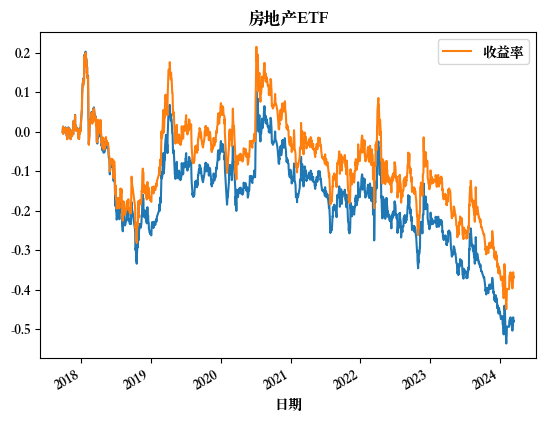

开始计算上证50ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：0
第 1 / 27 期（2017-09-01 00:00:00）: 260.31 + 89667.02 = 89927.33
第 2 / 27 期（2017-11-30 00:00:00）: 34.84 + 184210.36 = 184245.2
第 3 / 27 期（2018-02-28 00:00:00）: 103.18 + 274804.68 = 274907.86
第 4 / 27 期（2018-05-29 00:00:00）: 5.46 + 346671.66 = 346677.12
第 5 / 27 期（2018-08-27 00:00:00）: 10.58 + 427055.39 = 427065.97
第 6 / 27 期（2018-11-26 00:00:00）: 264.49 + 499324.4 = 499588.89
第 7 / 27 期（2019-02-25 00:00:00）: 171.47 + 662104.17 = 662275.64
第 8 / 27 期（2019-05-24 00:00:00）: 76.65 + 726761.96 = 726838.61
第 9 / 27 期（2019-08-22 00:00:00）: 63.45 + 870433.55 = 870497.0
第 10 / 27 期（2019-11-20 00:00:00）: 69.27 + 983600.87 = 983670.14
第 11 / 27 期（2020-02-18 00:00:00）: 90.29 + 1058440.28 = 1058530.57
第 12 / 27 期（2020-05-18 00:00:00）: 227.15 + 1123377.34 = 1123604.49
第 13 / 27 期（2020-08-17 00:00:00）: 216.95 + 1410842.68 = 1411059.63
第 14 / 27 期（2020-11-16 00:00:00）: 346.11 + 1504607.84 = 1504953.95
第 15 / 27 期（2021-02-18 00:00:00）: 182.26 + 1835942.21

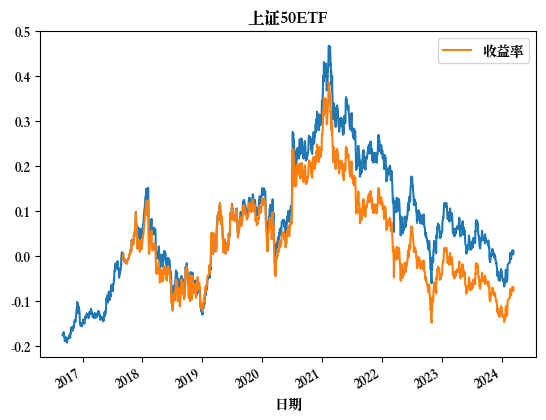

开始计算创业板ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：0
第 1 / 27 期（2017-09-01 00:00:00）: 100.25 + 89826.95 = 89927.2
第 2 / 27 期（2017-11-30 00:00:00）: 97.77 + 174041.23 = 174139.0
第 3 / 27 期（2018-02-28 00:00:00）: 84.07 + 262726.18 = 262810.25
第 4 / 27 期（2018-05-29 00:00:00）: 109.09 + 356924.86 = 357033.95
第 5 / 27 期（2018-08-27 00:00:00）: 94.29 + 393264.22 = 393358.51
第 6 / 27 期（2018-11-26 00:00:00）: 118.91 + 432974.54 = 433093.45
第 7 / 27 期（2019-02-25 00:00:00）: 117.13 + 609219.92 = 609337.05
第 8 / 27 期（2019-05-24 00:00:00）: 122.95 + 655042.21 = 655165.16
第 9 / 27 期（2019-08-22 00:00:00）: 112.15 + 825440.51 = 825552.66
第 10 / 27 期（2019-11-20 00:00:00）: 45.93 + 969082.12 = 969128.05
第 11 / 27 期（2020-02-18 00:00:00）: 141.78 + 1313626.9 = 1313768.68
第 12 / 27 期（2020-05-18 00:00:00）: 187.71 + 1371453.12 = 1371640.83
第 13 / 27 期（2020-08-17 00:00:00）: 212.03 + 1843398.8 = 1843610.83
第 14 / 27 期（2020-11-16 00:00:00）: 49.78 + 1942680.29 = 1942730.07
第 15 / 27 期（2021-02-18 00:00:00）: 39.38 + 2464159.76

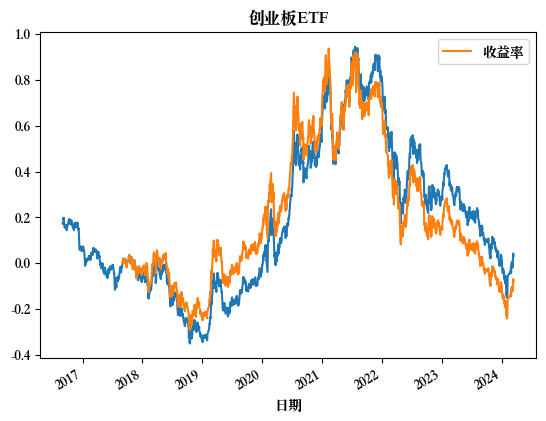

开始计算标普500ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：0
第 1 / 27 期（2017-09-01 00:00:00）: 26.62 + 89900.53 = 89927.15
第 2 / 27 期（2017-11-30 00:00:00）: 120.27 + 185591.96 = 185712.23
第 3 / 27 期（2018-02-28 00:00:00）: 9.54 + 278062.58 = 278072.12
第 4 / 27 期（2018-05-29 00:00:00）: 14.56 + 367128.07 = 367142.63
第 5 / 27 期（2018-08-27 00:00:00）: 22.98 + 503107.97 = 503130.95
第 6 / 27 期（2018-11-26 00:00:00）: 70.41 + 560386.53 = 560456.94
第 7 / 27 期（2019-02-25 00:00:00）: 78.23 + 662481.01 = 662559.24
第 8 / 27 期（2019-05-24 00:00:00）: 69.64 + 780591.2 = 780660.84
第 9 / 27 期（2019-08-22 00:00:00）: 144.08 + 919930.16 = 920074.24
第 10 / 27 期（2019-11-20 00:00:00）: 188.51 + 1068947.86 = 1069136.37
第 11 / 27 期（2020-02-18 00:00:00）: 62.27 + 1251160.77 = 1251223.04
第 12 / 27 期（2020-05-18 00:00:00）: 4.07 + 1176194.81 = 1176198.88
第 13 / 27 期（2020-08-17 00:00:00）: 162.74 + 1433644.06 = 1433806.8
第 14 / 27 期（2020-11-16 00:00:00）: 0.09 + 1543177.35 = 1543177.44
第 15 / 27 期（2021-02-18 00:00:00）: 51.43 + 1731480.64 =

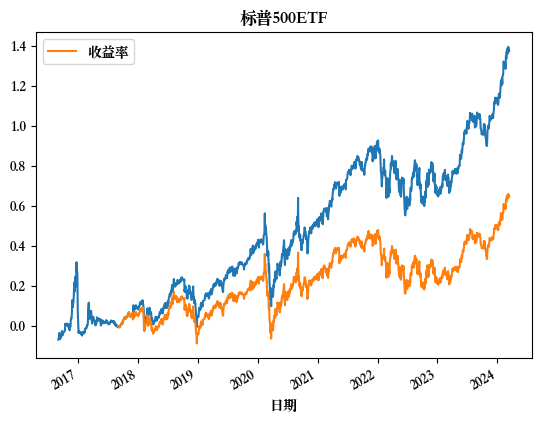

In [249]:
# 以房地产 ETF、上证 50 ETF、创业板 ETF、标普 500 ETF 为例
for i in [0, 3, 5, 12]:
    calc(stockNameCodes[i], datetime.timedelta(days=90))
    plt.show()

In [250]:
results: list[list[tuple[datetime.timedelta, Result]]] = []
res: list[pd.DataFrame] = []
for stockNameCode in stockNameCodes:
    results.append([])
    l: list[pd.DataFrame] = []
    for delta in deltas:
        r = calc(stockNameCode, delta, silent=True)
        final = r.asset
        ratio_1 = r.ratio
        extra = r.extra
        mdd = r.max_drawdown
        avgdd = r.avg_drawdown
        results[-1].append((delta, r))
        l.append(pd.DataFrame({
            "标的": stockNameCode[1], "投资周期": [delta],
            "价格变动率": [ratio_1-1], "收益率": [final-1],
            "交易费用": [extra],
            "最大回撤": [mdd], "平均回撤": [avgdd]
        }))
    res.append(pd.concat(l))
pd.concat(res).to_csv('result.csv', index=False)

In [252]:
table1: list[pd.DataFrame] = []
table2: list[pd.DataFrame] = []
table3: list[pd.DataFrame] = []
for i, l in enumerate(results):
    d1: dict[str, str | float] = {'标的': stockNameCodes[i][1], }
    d2: dict[str, str | float] = {'标的': stockNameCodes[i][1], }
    d3: dict[str, str | float] = {'标的': stockNameCodes[i][1], }
    for j, delta in enumerate(deltas):
        key = str(l[j][0].days)+" 天"
        d1[key] = l[j][1].gain
        d2[key] = l[j][1].max_drawdown
        d3[key] = l[j][1].avg_drawdown
    table1.append(pd.DataFrame.from_dict(d1, orient='index').T)
    table2.append(pd.DataFrame.from_dict(d2, orient='index').T)
    table3.append(pd.DataFrame.from_dict(d3, orient='index').T)

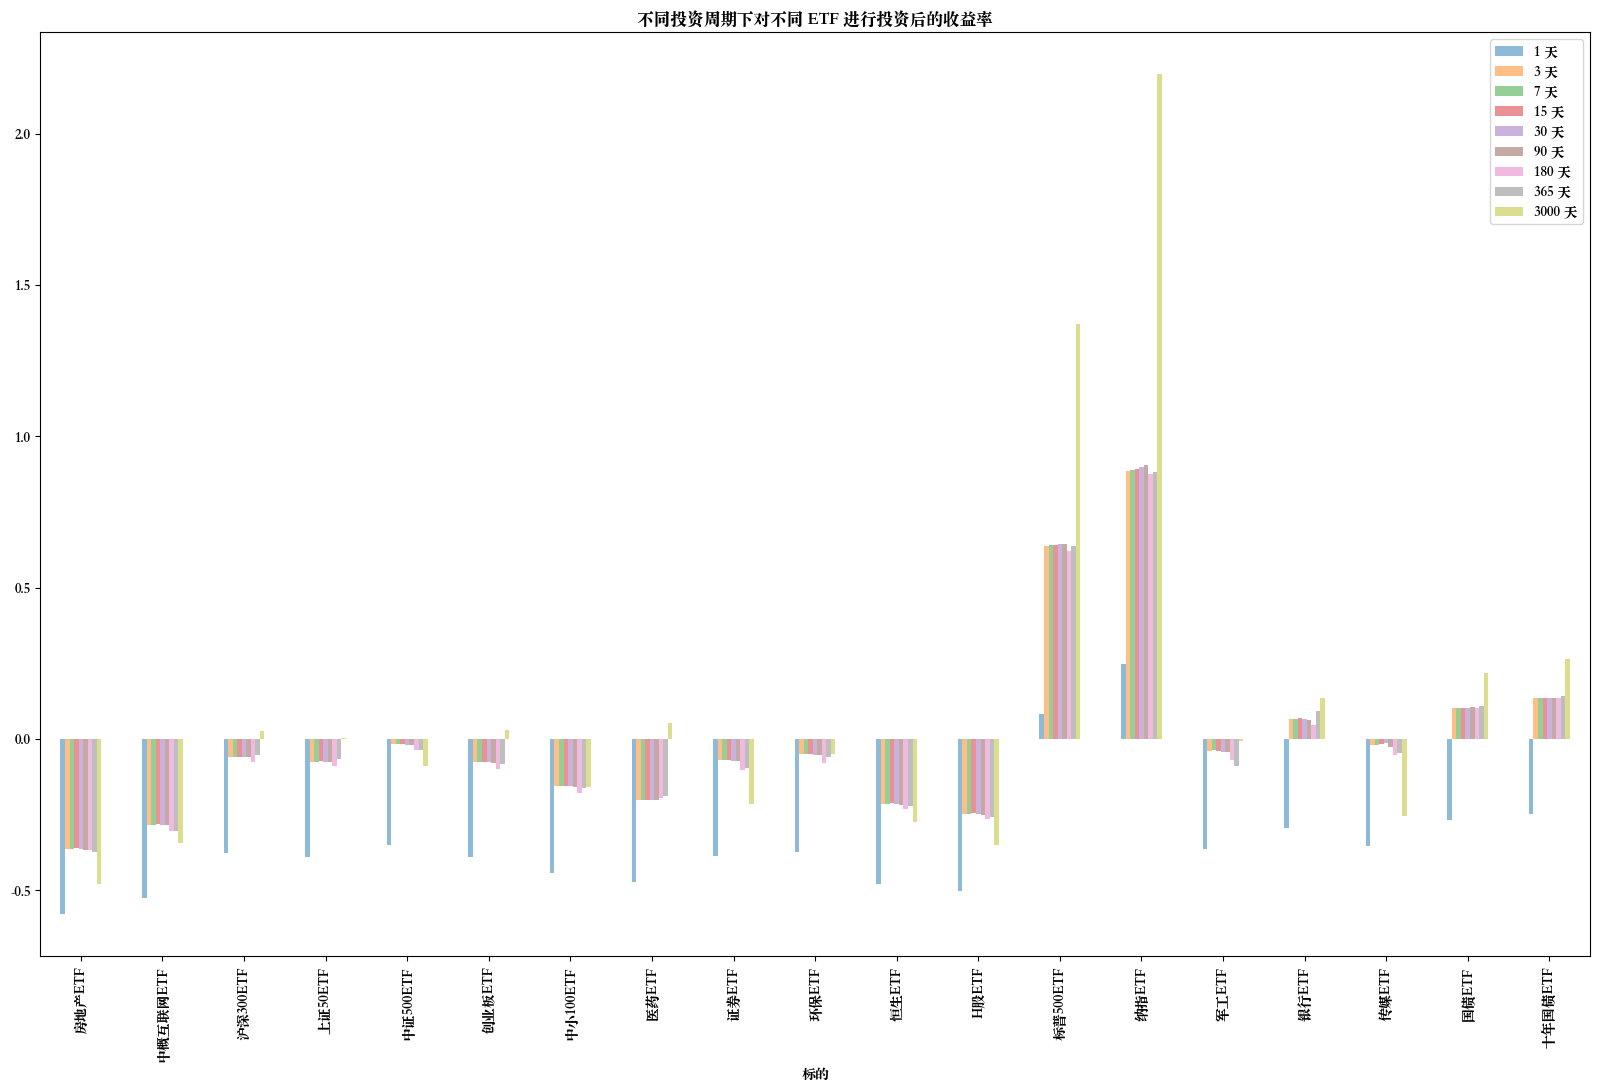

In [253]:
# 不同投资周期下使用每期五千元对不同标的进行投资后的收益率。
# 表格中高亮部分对应该标的收益最高的投资周期。

t = pd.concat(table1)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
# print(t.idxmax(axis=1))
t.plot(kind='bar', alpha=0.5, figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资后的收益率')
t.style.format(precision=3).highlight_max(axis='columns',
                                          color='lightgreen').highlight_min(axis='columns', color='yellow')

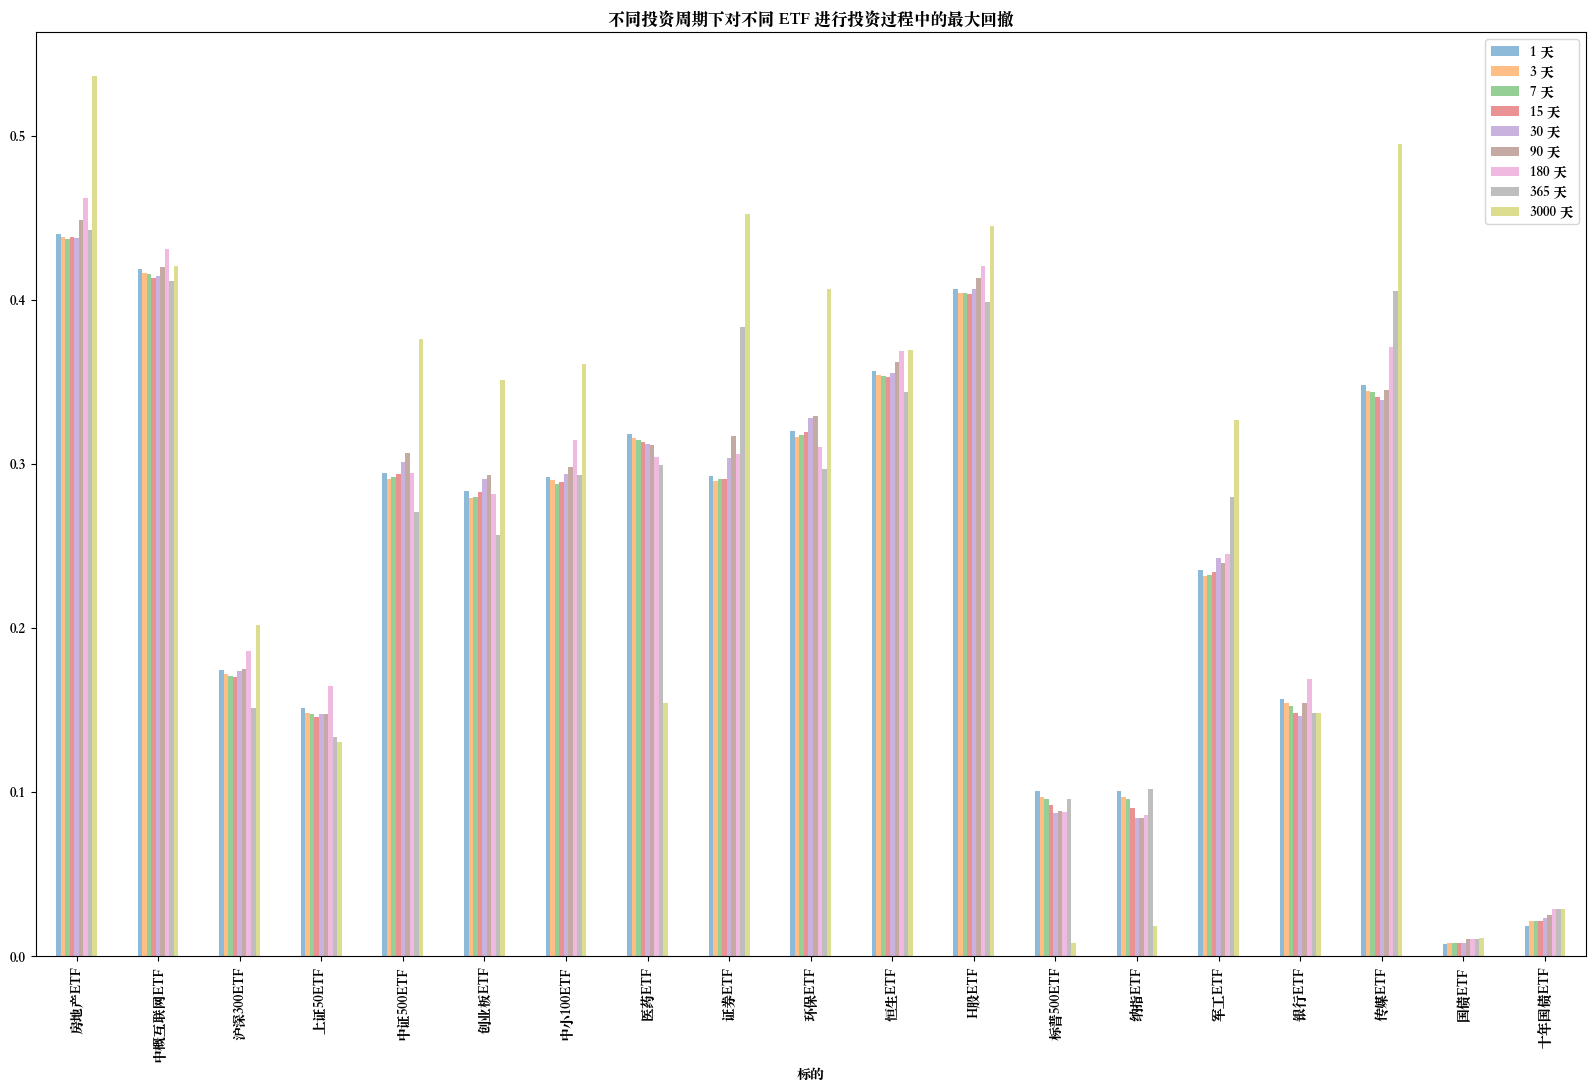

In [254]:
# 不同投资周期下使用每期五千元对不同标的进行投资过程中的最大回撤。
# 表格中高亮部分对应该标的的最大回撤的最大、最小值。

t = pd.concat(table2)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
t.plot(kind='bar', alpha=0.5, figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资过程中的最大回撤')
t.style.format(precision=3).highlight_min(axis='columns',
                                          color='lightgreen').highlight_max(axis='columns', color='yellow')

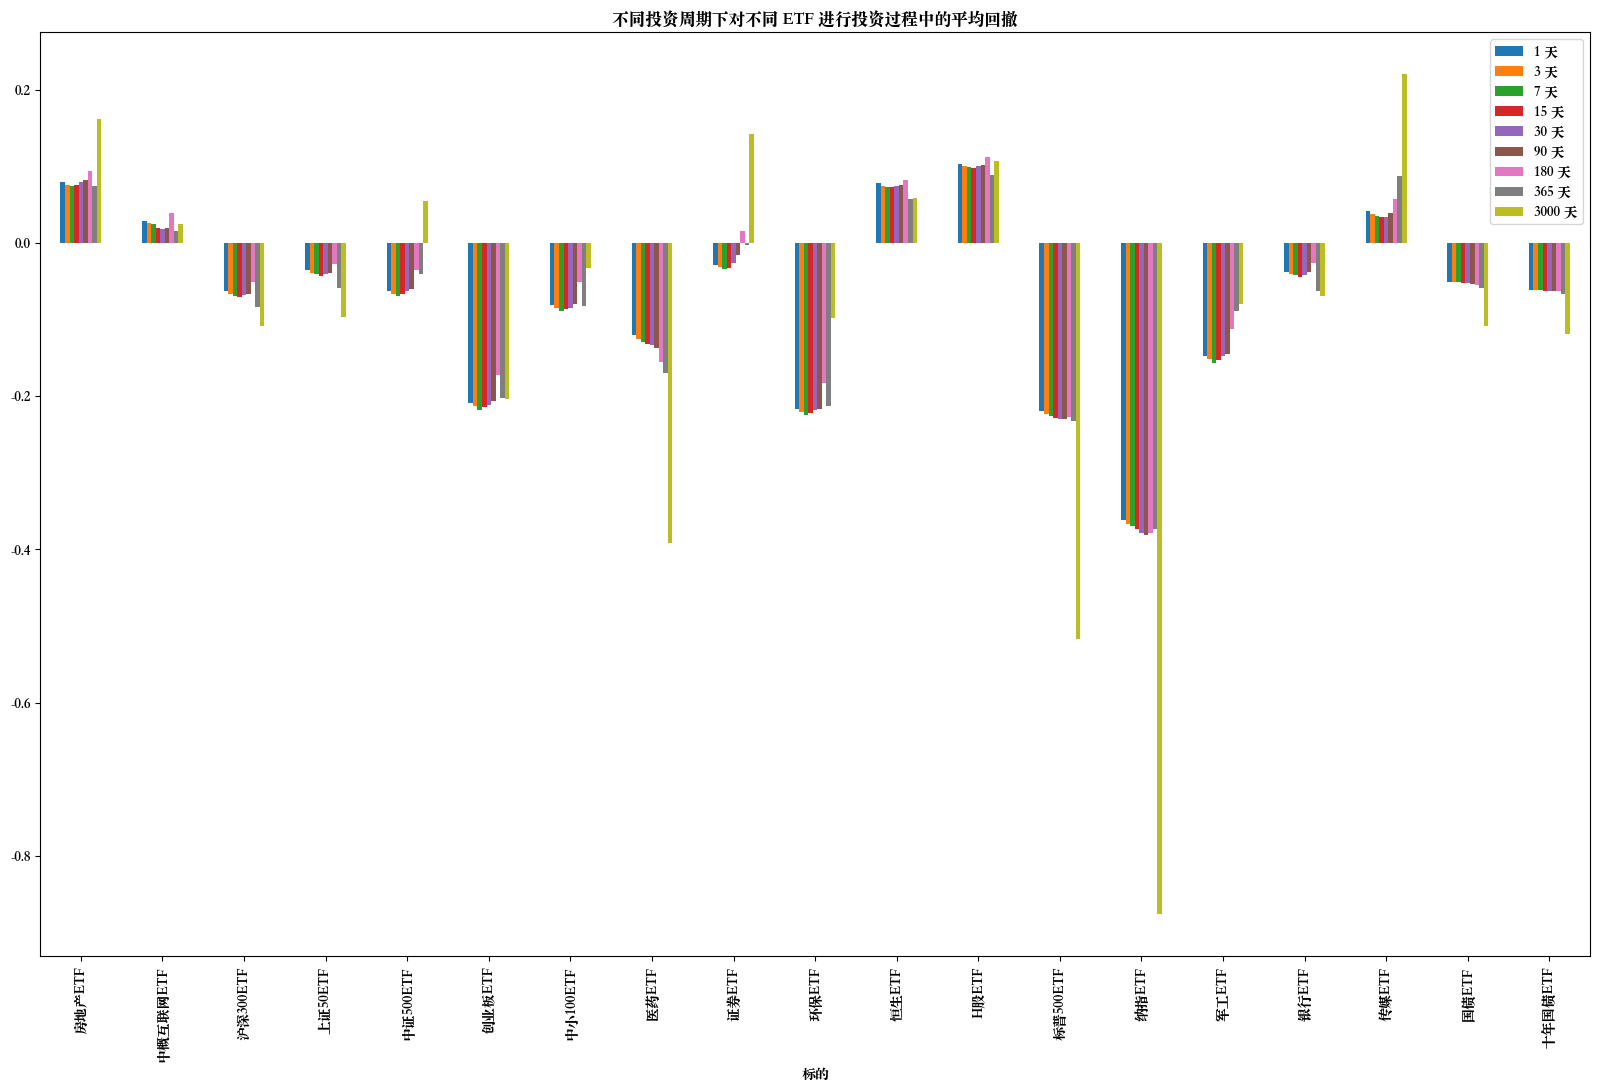

In [255]:
# 不同投资周期下使用每期五千元对不同标的进行投资过程中的平均回撤。
# 表格中高亮部分对应该标的的平均回撤的最大、最小值。

t = pd.concat(table3)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
t.plot(kind='bar', figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资过程中的平均回撤')
t.style.format(precision=3).highlight_min(axis='columns',
                                          color='lightgreen').highlight_max(axis='columns', color='yellow')

#### 对定期等额平均成本投资法和静态投资组合在一对 ETF 上的验证


In [219]:
from math import ceil, floor


def calcProfolio(stockNameCode: tuple[str, str], step: datetime.timedelta, silent: bool = False) -> Result:
    '''
    Returns a tuple of (asset, ratio)
    '''
    PROFOLIO_RATIO_MIN = 0.6
    PROFOLIO_RATIO_EXP = 0.7
    PROFOLIO_RATIO_MAX = 0.8
    PROFOLIO_BASE = '511260'
    df = allStockDaily[stockNameCode[0]]

    # 开始时间
    START = max(df.iloc[0, 0], start)
    END = min(df.iloc[-1, 0], end)

    # 总期数
    PERIODS_TOTAL: int = (END-START)//step+1
    # 剩余期数
    periods = PERIODS_TOTAL
    # 开始时间
    cur: pd.DatetimeIndex = START
    # 初始资金：每日一千
    # 似乎有点少，但是这样可以更好地体现出投资的风险
    MONEY_PER_PERIOD = step.days*1000
    INIT = MONEY_PER_PERIOD * PERIODS_TOTAL
    money = 0
    # 基金数量（以 100 份为单位）
    stock_1 = 0
    stock_2 = 0
    extra = ExtraCost(silent=silent)

    min_asset = 1
    record_assets: list[float] = []

    if not silent:
        print(f"开始计算{stockNameCode[1]}")
        print(f"总期数：{PERIODS_TOTAL}")
        print(f"开始时间：{cur}")
        print(f"总资金：{PERIODS_TOTAL*MONEY_PER_PERIOD}")

    l = []

    i = 1
    for date, row in df.loc[start:].iterrows():
        # 日期
        date: pd.DatetimeIndex
        # 当日价格
        price_1: float = row[D]
        # print(allStockDaily[PROFOLIO_BASE].loc[:date])
        price_2: float = allStockDaily[PROFOLIO_BASE].loc[:date].iloc[-1, D]
        value_1_now = stock_1*100*price_1
        value_2_now = stock_2*100*price_2

        value_total_now = value_1_now+value_2_now

        if cur <= date:
            # 本期准备使用的资金金额，大约每日一千
            money += MONEY_PER_PERIOD
            EXPECT_STOCK_1 = \
                (value_total_now+money) * PROFOLIO_RATIO_EXP / price_1 / 100
            EXPECT_STOCK_2 = \
                (value_total_now+money) * (1-PROFOLIO_RATIO_EXP) / price_2 / 100

            if value_1_now/(value_total_now+money) > PROFOLIO_RATIO_MAX and EXPECT_STOCK_2 > 1:
                # 如果 1 的价值占比超过最大比例，卖出 1
                stock_1_to_sell = floor(EXPECT_STOCK_1-stock_1)
                money += extra.sell(stock_1_to_sell*100*price_1, store=True)
                stock_1 -= stock_1_to_sell
                # 剩下的钱全用来买 2
                stock_2_to_buy = floor(money/price_2/100)
                money -= extra.buy(stock_2_to_buy*price_2*100, store=True)
                stock_2 += stock_2_to_buy
            elif (value_1_now+money)/(value_total_now+money) < PROFOLIO_RATIO_MIN:
                # 如果 1 的价值占比低于最小比例，卖出 2
                stock_2_to_sell = floor(EXPECT_STOCK_2-stock_2)
                money += extra.sell(stock_2_to_sell*100*price_2, store=True)
                stock_2 -= stock_2_to_sell
                # 剩下的钱全用来买 1
                stock_1_to_buy = floor(money/price_1/100)
                money -= extra.buy(stock_1_to_buy*price_1*100, store=True)
                stock_1 += stock_1_to_buy
            else:
                stock_1_to_buy = 0
                stock_2_to_buy = 0
                if stock_1 <= EXPECT_STOCK_1 and stock_2 <= EXPECT_STOCK_2:
                    stock_1_to_buy = floor(EXPECT_STOCK_1)-stock_1
                    stock_2_to_buy = floor(EXPECT_STOCK_2)-stock_2
                elif stock_1 <= EXPECT_STOCK_1:
                    stock_1_to_buy = max(floor(money/price_1/100)-stock_1, 0)
                    assert stock_1_to_buy >= 0, f"{stock_1_to_buy} < 0, {stock_2_to_buy}"
                elif stock_2 <= EXPECT_STOCK_2:
                    stock_2_to_buy = max(floor(money/price_2/100)-stock_2, 0)
                    assert stock_2_to_buy >= 0, f"{stock_2_to_buy} < 0, {stock_1_to_buy}"
                else:
                    assert False, "不可能出现的情况"
                assert money >= 0, f"{money} < 0"

                assert stock_1_to_buy >= 0, f"{stock_1_to_buy} < 0, {stock_2_to_buy}"
                assert stock_2_to_buy >= 0, f"{stock_2_to_buy} < 0, {stock_1_to_buy}"

                while money < extra.buy(stock_1_to_buy*100*price_1, store=False) + extra.buy(stock_2_to_buy*100*price_2, store=False):
                    if stock_1_to_buy > 0:
                        stock_1_to_buy -= 1
                    elif stock_2_to_buy > 0:
                        stock_2_to_buy -= 1
                    else:
                        assert False, "不可能出现的情况"
                assert money >= 0, f"{money} < 0"
                if stock_1_to_buy > 0:
                    stock_1 += stock_1_to_buy
                    value_stock_1_to_buy = stock_1_to_buy*100*price_1
                    money -= extra.buy(value_stock_1_to_buy, store=True)
                if stock_2_to_buy > 0:
                    stock_2 += stock_2_to_buy
                    value_stock_2_to_buy = stock_2_to_buy*100*price_2
                    money -= extra.buy(value_stock_2_to_buy, store=True)
                assert money >= 0, f"{money} < 0"

            if not silent:
                STOCK_PRICE_1 = extra.sell(
                    stock_1*100*price_1, store=False)
                STOCK_PRICE_2 = extra.sell(stock_2*100*price_2, store=False)
                print(
                    f"第 {i} / {PERIODS_TOTAL} 期（{date}）: "
                    f"{money:.2f} + {STOCK_PRICE_1} + {STOCK_PRICE_2} = {round(money+STOCK_PRICE_1+STOCK_PRICE_2, 2)}")
            cur += step
            i += 1
            periods -= 1
        else:
            EXPECT_STOCK_1 = value_total_now * PROFOLIO_RATIO_EXP / price_1 / 100
            EXPECT_STOCK_2 = value_total_now * \
                (1-PROFOLIO_RATIO_EXP) / price_2 / 100
            # print(EXPECT_STOCK_1, EXPECT_STOCK_2,
            #       value_1_now, value_2_now, value_total_now)
            if value_1_now / value_total_now > PROFOLIO_RATIO_MAX and EXPECT_STOCK_2 > 1:
                # 如果 1 的价值占比超过最大比例，卖出 1
                stock_1_to_sell = floor(stock_1-EXPECT_STOCK_1)
                money += extra.sell(stock_1_to_sell*100*price_1, store=True)
                stock_1 -= stock_1_to_sell
                # 剩下的钱全用来买 2
                stock_2_to_buy = floor(money/price_2/100)
                money -= extra.buy(stock_2_to_buy*price_2*100, store=True)
                stock_2 += stock_2_to_buy
            elif value_1_now / value_total_now < PROFOLIO_RATIO_MIN:
                # 如果 1 的价值占比低于最小比例，卖出 2
                stock_2_to_sell = floor(stock_2-EXPECT_STOCK_2)
                money += extra.sell(stock_2_to_sell*100*price_2, store=True)
                stock_2 -= stock_2_to_sell
                # 剩下的钱全用来买 1
                stock_1_to_buy = floor(money/price_1/100)
                money -= extra.buy(stock_1_to_buy*price_1*100, store=True)
                stock_1 += stock_1_to_buy
            else:
                # 无需调整
                pass

        # 当前资产
        asset_now = (money+extra.sell(stock_1*100*price_1, store=False) +
                     extra.sell(stock_2*100*price_2, store=False))/((i-1)*MONEY_PER_PERIOD)
        min_asset = min(min_asset, asset_now)
        record_assets.append(asset_now)
        l.append(pd.DataFrame(
            [{'日期': date, '资产': asset_now, '收益率': asset_now-1}]))

    if not silent:
        ax = plt.axes(title=stockNameCode[1])
        # 价格变动率
        # print(df.iloc[:, D])
        normalized = pd.DataFrame(df.iloc[:, D]/df.loc[start:].iloc[0, D]-1)
        normalized.columns = ['价格变动率']
        # 不太能理解的是这个地方为什么不能正常显示标签。
        # normalized.set_index('日期', drop=True, inplace=True)
        # print(normalized)
        normalized.plot(ax=ax, y='价格变动率', label='价格变动率')

        # 收益率
        asset = pd.DataFrame(columns=['日期', '收益率'])
        asset = pd.concat([asset, *l])
        asset.set_index('日期', drop=True, inplace=True)
        # print(asset)
        asset.plot(ax=ax, y='收益率', label='收益率')
    price_1: float = df.loc[end:].iloc[-1, D]
    price_2: float = allStockDaily[PROFOLIO_BASE].loc[end:].iloc[-1, D]
    ratio_1: float = price_1/df.loc[start:].iloc[0, D]
    ratio_2: float = price_2 / \
        allStockDaily[PROFOLIO_BASE].loc[start:].iloc[0, D]
    final_1 = round(extra.sell(stock_1*100*price_1, store=True), 2)
    final_2 = round(extra.sell(stock_2*100*price_2, store=True), 2)
    asset_ratio = round(final_1+final_2+money, 2)/INIT
    max_drawdown = 1-min_asset
    avg_drawdown = 1-np.mean(record_assets)
    if not silent:
        print(f"剩余资金：{money}")
        print(f"股基数量：{stock_1*100}")
        print(f"债基数量：{stock_2*100}")
        print(f"股基单价：{price_1}")
        print(f"债基单价：{price_2}")
        print(f"股基单价变动率：{ratio_1-1}")
        print(f"债基单价变动率：{ratio_2-1}")
        print(f"基金名称：{stockNameCode[1]}")
        print(f"交易费用：{extra.get()}")
        print(f"最大回撤：{max_drawdown}")
        print(f"平均回撤；{avg_drawdown}")
        print(
            f"最终资产：{final_1} + {final_2} + {money} = {round(final_1+final_2+money,2)}")
        print(f"收益率：{asset_ratio-1}")
    return Result(asset_ratio, asset_ratio-1, ratio_1, ratio_1-1, extra.get(), max_drawdown, avg_drawdown, PERIODS_TOTAL)

开始计算房地产ETF
总期数：27
开始时间：2017-09-25 00:00:00
总资金：2430000
第 1 / 27 期（2017-09-25 00:00:00）: 6872.84 + 62957.91 + 20099.17 = 89929.92
第 2 / 27 期（2017-12-25 00:00:00）: 4873.10 + 125646.64 + 49058.9 = 179578.64
第 3 / 27 期（2018-03-26 00:00:00）: 110.51 + 186348.23 + 79725.7 = 266184.44
第 4 / 27 期（2018-06-22 00:00:00）: 1203.51 + 240078.82 + 101744.23 = 343026.56
第 5 / 27 期（2018-09-20 00:00:00）: 34.75 + 285337.16 + 122311.38 = 407683.29
第 6 / 27 期（2018-12-19 00:00:00）: 381.56 + 343422.27 + 146775.86 = 490579.69
第 7 / 27 期（2019-03-19 00:00:00）: 1226.69 + 474226.49 + 202074.97 = 677528.15
第 8 / 27 期（2019-06-17 00:00:00）: 6408.09 + 511730.46 + 212932.4 = 731070.95
第 9 / 27 期（2019-09-16 00:00:00）: 204.75 + 579080.29 + 247952.94 = 827237.98
第 10 / 27 期（2019-12-16 00:00:00）: 8922.35 + 648784.7 + 269121.73 = 926828.78
第 11 / 27 期（2020-03-13 00:00:00）: 9696.08 + 703899.69 + 292057.16 = 1005652.93
第 12 / 27 期（2020-06-11 00:00:00）: 10500.14 + 757353.2 + 314089.28 = 1081942.62
第 13 / 27 期（2020-09-09 00:00:0

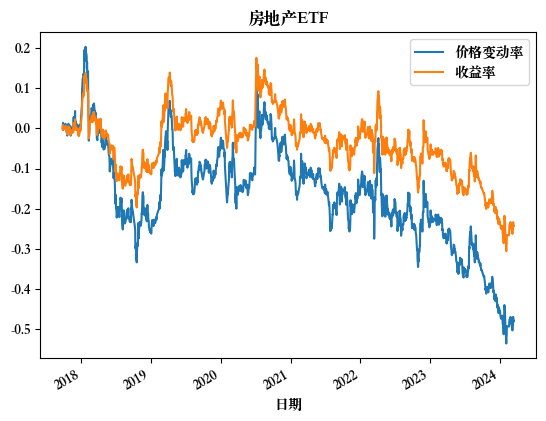

开始计算上证50ETF
总期数：27
开始时间：2017-09-01 00:00:00
总资金：2430000
第 1 / 27 期（2017-09-01 00:00:00）: 7293.18 + 62673.83 + 19963.21 = 89930.22
第 2 / 27 期（2017-11-30 00:00:00）: 6047.92 + 127580.32 + 48889.97 = 182518.21
第 3 / 27 期（2018-02-28 00:00:00）: 2753.78 + 191481.03 + 79539.39 = 273774.2
第 4 / 27 期（2018-05-29 00:00:00）: 4310.14 + 246881.49 + 101590.3 = 352781.93
第 5 / 27 期（2018-08-27 00:00:00）: 8512.83 + 305378.73 + 122619.65 = 436511.21
第 6 / 27 期（2018-11-26 00:00:00）: 8941.17 + 361540.47 + 146234.3 = 516715.94
第 7 / 27 期（2019-02-25 00:00:00）: 7842.27 + 462820.61 + 190923.07 = 661585.95
第 8 / 27 期（2019-05-24 00:00:00）: 8896.28 + 512842.38 + 211211.14 = 732949.8
第 9 / 27 期（2019-08-22 00:00:00）: 350.45 + 606002.3 + 259330.84 = 865683.59
第 10 / 27 期（2019-11-20 00:00:00）: 944.68 + 679251.79 + 290411.27 = 970607.74
第 11 / 27 期（2020-02-18 00:00:00）: 7603.61 + 741044.41 + 310050.62 = 1058698.64
第 12 / 27 期（2020-05-18 00:00:00）: 3176.19 + 795476.2 + 337765.7 = 1136418.09
第 13 / 27 期（2020-08-17 00:00:

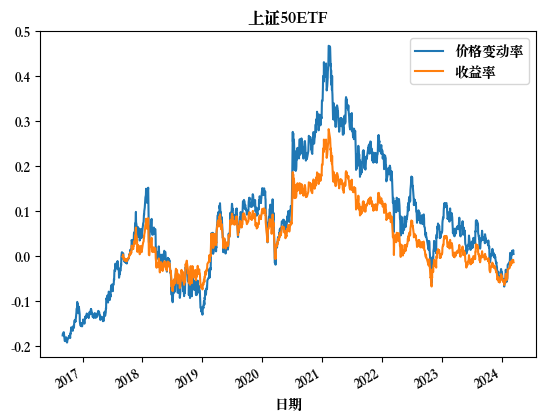

开始计算创业板ETF
总期数：27
开始时间：2017-09-01 00:00:00
总资金：2430000
第 1 / 27 期（2017-09-01 00:00:00）: 7123.52 + 62843.36 + 19963.21 = 89930.09
第 2 / 27 期（2017-11-30 00:00:00）: 3882.31 + 122676.63 + 48889.97 = 175448.91
第 3 / 27 期（2018-02-28 00:00:00）: 112.89 + 185657.64 + 79539.39 = 265309.92
第 4 / 27 期（2018-05-29 00:00:00）: 6492.38 + 251927.22 + 101590.3 = 360009.9
第 5 / 27 期（2018-08-27 00:00:00）: 1287.10 + 288783.37 + 122619.65 = 412690.12
第 6 / 27 期（2018-11-26 00:00:00）: 4792.93 + 327901.74 + 135788.99 = 468483.66
第 7 / 27 期（2019-02-25 00:00:00）: 7554.19 + 438011.97 + 180316.23 = 625882.39
第 8 / 27 期（2019-05-24 00:00:00）: 4419.42 + 478243.07 + 200650.59 = 683313.08
第 9 / 27 期（2019-08-22 00:00:00）: 2503.90 + 585606.09 + 248525.39 = 836635.38
第 10 / 27 期（2019-11-20 00:00:00）: 9382.02 + 674453.36 + 279655.3 = 963490.68
第 11 / 27 期（2020-02-18 00:00:00）: 6332.46 + 867185.95 + 365416.81 = 1238935.22
第 12 / 27 期（2020-05-18 00:00:00）: 159.68 + 919601.2 + 394059.98 = 1313820.86
第 13 / 27 期（2020-08-17 00:0

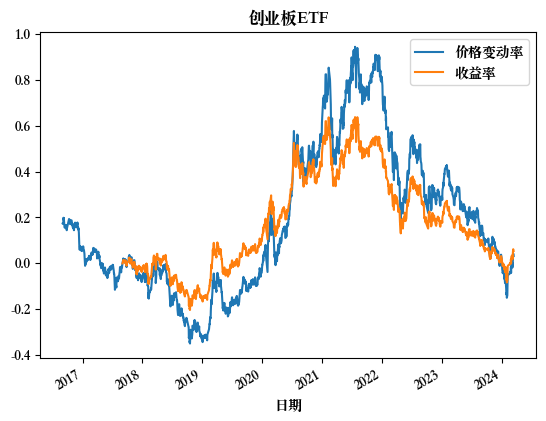

开始计算标普500ETF
总期数：27
开始时间：2017-09-01 00:00:00
总资金：2430000
第 1 / 27 期（2017-09-01 00:00:00）: 7126.72 + 62840.16 + 19963.21 = 89930.09
第 2 / 27 期（2017-11-30 00:00:00）: 6228.80 + 128425.15 + 48889.97 = 183543.92
第 3 / 27 期（2018-02-28 00:00:00）: 3381.03 + 193053.96 + 79539.39 = 275974.38
第 4 / 27 期（2018-05-29 00:00:00）: 8624.29 + 256827.92 + 101590.3 = 367042.51
第 5 / 27 期（2018-08-27 00:00:00）: 3978.04 + 342746.86 + 143056.26 = 489781.16
第 6 / 27 期（2018-11-26 00:00:00）: 1175.35 + 392372.7 + 167124.9 = 560672.95
第 7 / 27 期（2019-02-25 00:00:00）: 7627.64 + 463162.75 + 190923.07 = 661713.46
第 8 / 27 期（2019-05-24 00:00:00）: 9483.46 + 539251.62 + 221771.69 = 770506.77
第 9 / 27 期（2019-08-22 00:00:00）: 10692.62 + 629740.5 + 259330.84 = 899763.96
第 10 / 27 期（2019-11-20 00:00:00）: 7521.62 + 720293.14 + 301167.25 = 1028982.01
第 11 / 27 期（2020-02-18 00:00:00）: 2775.63 + 832769.76 + 354343.57 = 1189888.96
第 12 / 27 期（2020-05-18 00:00:00）: 92775.63 + 722978.59 + 360283.41 = 1176037.63
第 13 / 27 期（2020-08-

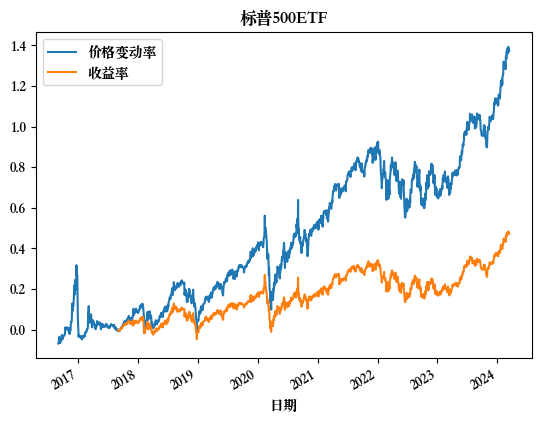

In [220]:
# 以房地产 ETF、上证 50 ETF、创业板 ETF、标普 500 ETF 为例
for i in [0, 3, 5, 12]:
    calcProfolio(stockNameCodes[i], datetime.timedelta(days=90))
    plt.show()

In [221]:
results: list[list[tuple[datetime.timedelta, Result]]] = []
res: list[pd.DataFrame] = []
for stockNameCode in stockNameCodes:
    results.append([])
    l: list[pd.DataFrame] = []
    for delta in deltas:
        r = calcProfolio(stockNameCode, delta, silent=True)
        final = r.asset
        ratio_1 = r.ratio
        extra = r.extra
        mdd = r.max_drawdown
        avgdd = r.avg_drawdown
        results[-1].append((delta, r))
        l.append(pd.DataFrame({
            "标的": stockNameCode[1], "投资周期": [delta],
            "价格变动率": [ratio_1-1], "收益率": [final-1],
            "交易费用": [extra],
            "最大回撤": [mdd], "平均回撤": [avgdd]
        }))
    res.append(pd.concat(l))
pd.concat(res).to_csv('result_profolio.csv', index=False)

/var/folders/t_/9rkxz6xn40q75nc_5vzm9h6r0000gn/T/ipykernel_7379/172920444.py:137: RuntimeWarning: invalid value encountered in scalar divide
  if value_1_now / value_total_now > PROFOLIO_RATIO_MAX and EXPECT_STOCK_2 > 1:
/var/folders/t_/9rkxz6xn40q75nc_5vzm9h6r0000gn/T/ipykernel_7379/172920444.py:146: RuntimeWarning: invalid value encountered in scalar divide
  elif value_1_now / value_total_now < PROFOLIO_RATIO_MIN:
/var/folders/t_/9rkxz6xn40q75nc_5vzm9h6r0000gn/T/ipykernel_7379/172920444.py:137: RuntimeWarning: invalid value encountered in scalar divide
  if value_1_now / value_total_now > PROFOLIO_RATIO_MAX and EXPECT_STOCK_2 > 1:
/var/folders/t_/9rkxz6xn40q75nc_5vzm9h6r0000gn/T/ipykernel_7379/172920444.py:146: RuntimeWarning: invalid value encountered in scalar divide
  elif value_1_now / value_total_now < PROFOLIO_RATIO_MIN:
/var/folders/t_/9rkxz6xn40q75nc_5vzm9h6r0000gn/T/ipykernel_7379/172920444.py:137: RuntimeWarning: invalid value encountered in scalar divide
  if value_1_now 

In [222]:
table1: list[pd.DataFrame] = []
table2: list[pd.DataFrame] = []
table3: list[pd.DataFrame] = []
for i, l in enumerate(results):
    d1: dict[str, str | float] = {'标的': stockNameCodes[i][1], }
    d2: dict[str, str | float] = {'标的': stockNameCodes[i][1], }
    d3: dict[str, str | float] = {'标的': stockNameCodes[i][1], }
    for j, delta in enumerate(deltas):
        key = str(l[j][0].days)+" 天"
        d1[key] = l[j][1].gain
        d2[key] = l[j][1].max_drawdown
        d3[key] = l[j][1].avg_drawdown
    table1.append(pd.DataFrame.from_dict(d1, orient='index').T)
    table2.append(pd.DataFrame.from_dict(d2, orient='index').T)
    table3.append(pd.DataFrame.from_dict(d3, orient='index').T)

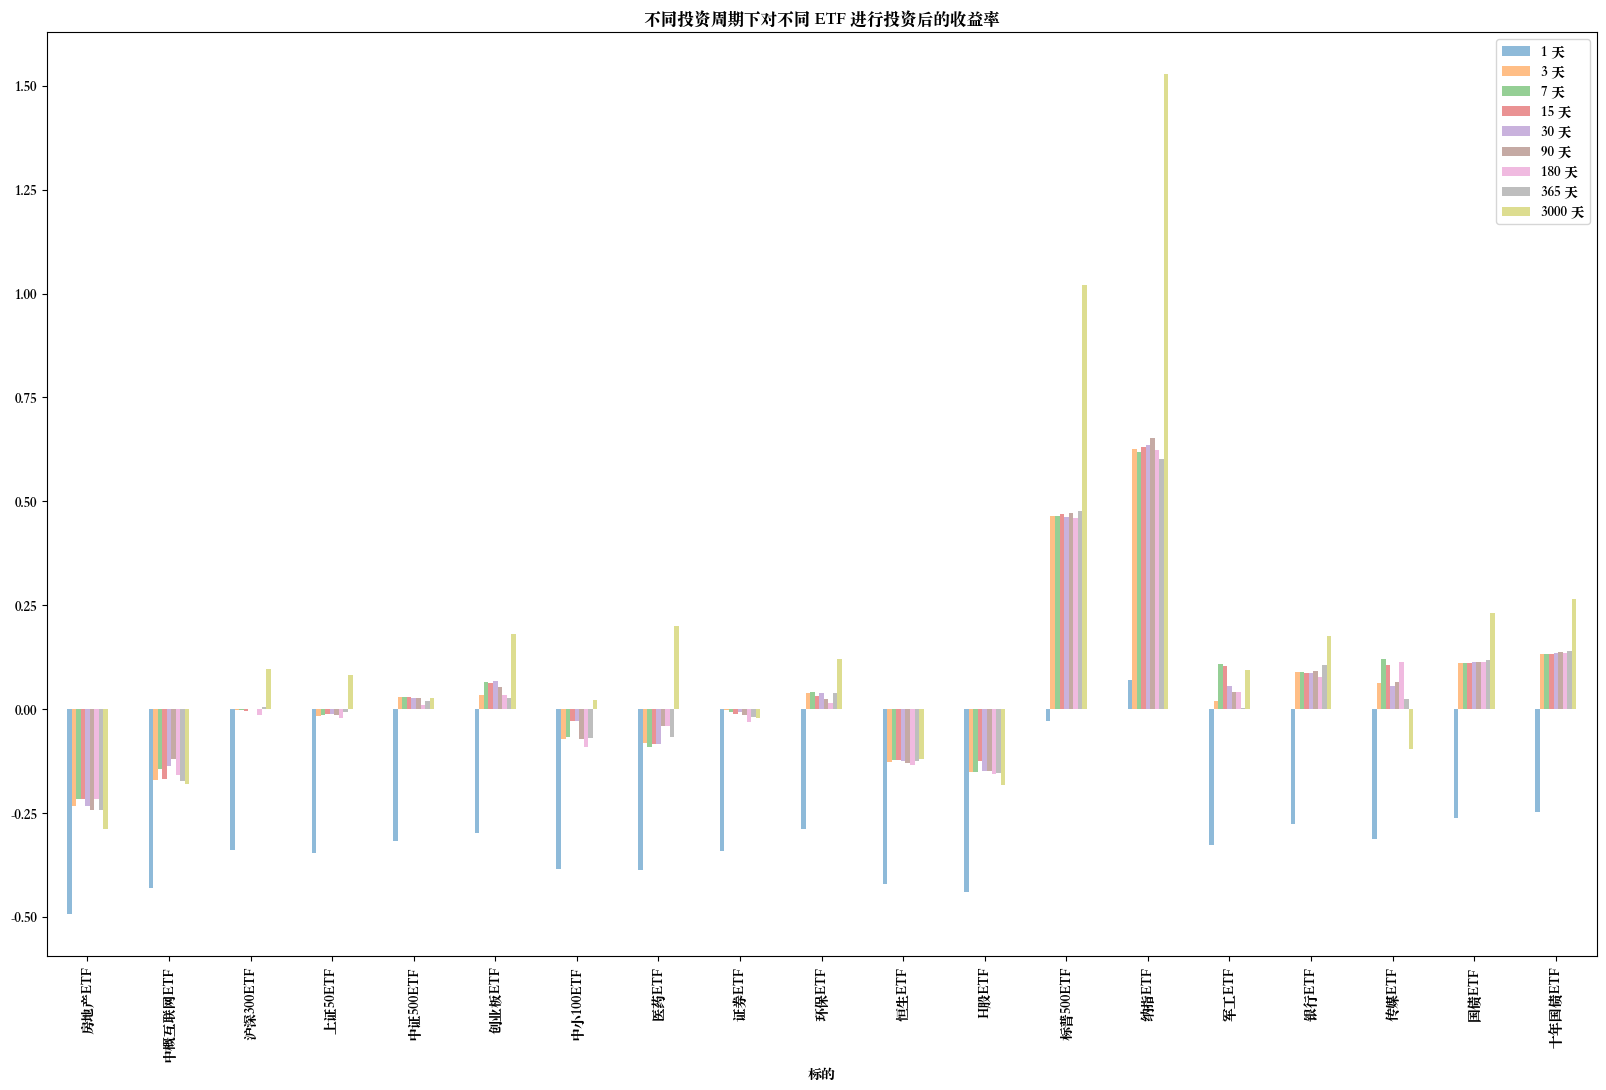

In [223]:
# 不同投资周期下使用每期五千元对不同标的进行投资后的收益率。
# 表格中高亮部分对应该标的收益最高的投资周期。

t = pd.concat(table1)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
# print(t.idxmax(axis=1))
t.plot(kind='bar', alpha=0.5, figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资后的收益率')
t.style.format(precision=3).highlight_max(axis='columns',
                                          color='lightgreen').highlight_min(axis='columns', color='yellow')

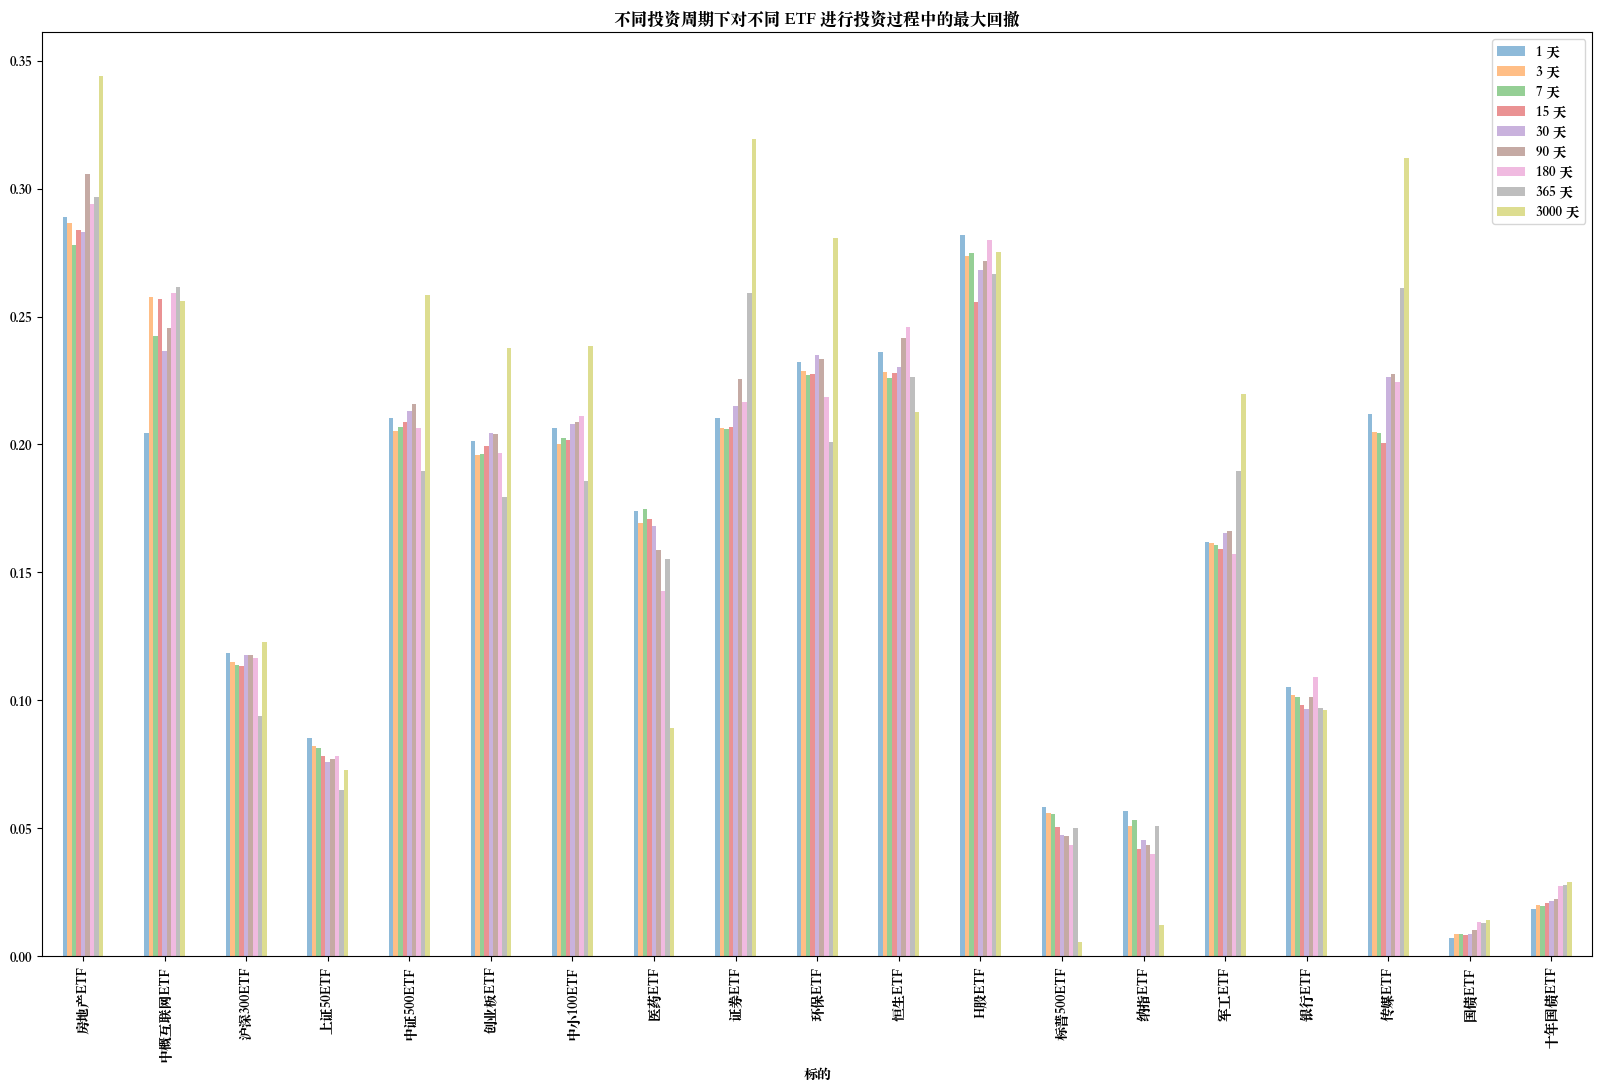

In [224]:
# 不同投资周期下使用每期五千元对不同标的进行投资过程中的最大回撤。
# 表格中高亮部分对应该标的的最大回撤的最大、最小值。

t = pd.concat(table2)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
t.plot(kind='bar', alpha=0.5, figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资过程中的最大回撤')
t.style.format(precision=3).highlight_min(axis='columns',
                                          color='lightgreen').highlight_max(axis='columns', color='yellow')

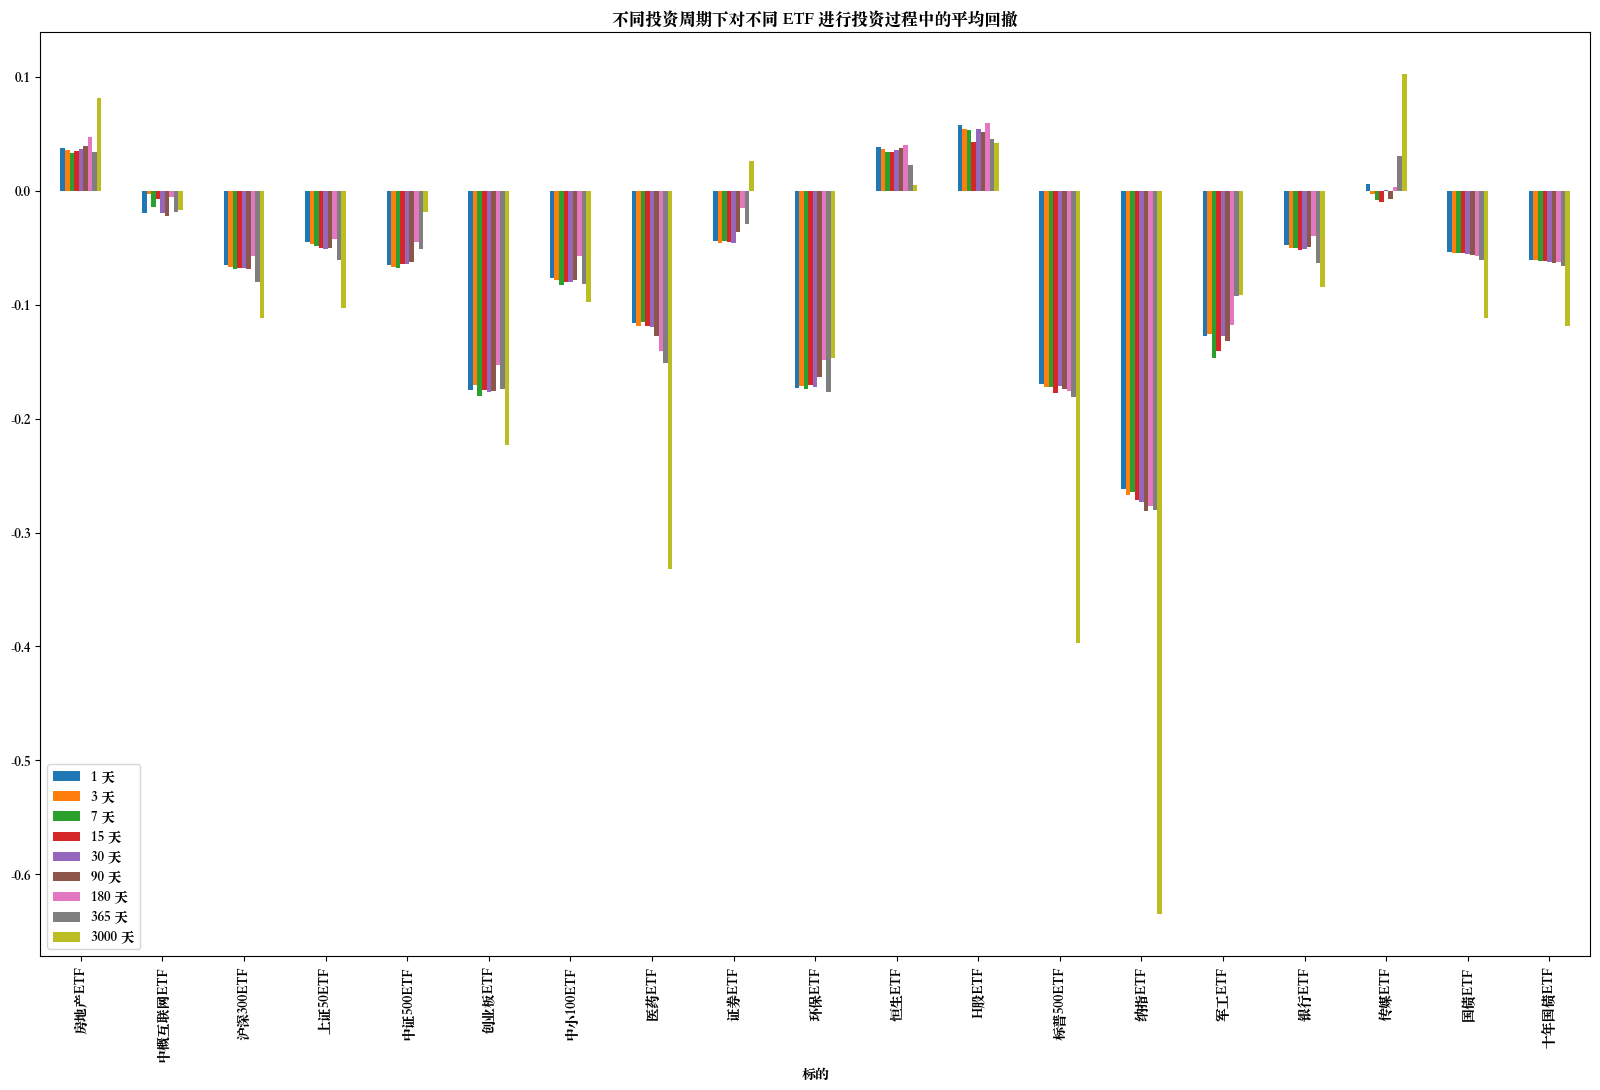

In [225]:
# 不同投资周期下使用每期五千元对不同标的进行投资过程中的平均回撤。
# 表格中高亮部分对应该标的的平均回撤的最大、最小值。

t = pd.concat(table3)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
t.plot(kind='bar', figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资过程中的平均回撤')
t.style.format(precision=3).highlight_min(axis='columns',
                                          color='lightgreen').highlight_max(axis='columns', color='yellow')

#### 对定期等额平均成本投资法和动态投资组合在一组 ETF 上的验证

##### 基本框架

接下来的代码将根据一定策略计算并调整投资组合。

参考了 <https://zhuanlan.zhihu.com/p/60499205>。


In [226]:
from typing import Callable
from scipy.stats import normaltest
from typing import Any


# 由于上市较晚，除去房地产 ETF 和传媒 ETF
# 再去掉两只国债 ETF
stockNameCodesExcept = [(code, name)
                        for code, name in stockNameCodes if code not in ['512200', '512980', '511010', '511260']]
allStockDailyExcept = {code: stock for code,
                       stock in allStockDaily.items() if code not in ['512200', '512980', '511010', '511260']}


def calc_portfolio(step: datetime.timedelta, method: str, optimizer: Callable[[pd.DataFrame], np.ndarray], print_weight: bool = True, silent: bool = False) -> tuple[float, float, pd.DataFrame]:
    '''
    Returns a tuple of (asset, ratio)
    '''

    # 总期数
    PERIODS_TOTAL: int = (end-start)//step+1
    # 剩余期数
    periods = PERIODS_TOTAL
    # 开始时间
    cur: pd.DatetimeIndex = start
    # 初始资金：一百万
    INIT = 1000000
    money = INIT
    # 基金数量
    stocks = 0
    # 交易费用
    extra = ExtraCost(silent=silent)

    if not silent:
        print(f"总期数：{PERIODS_TOTAL}")
        print(f"开始时间：{cur}")
        print(f"初始资金：{money}")

    l = []

    i = 1

    # 持有量
    stocks = np.array([0 for _ in range(len(stockNameCodesExcept))])

    expectation: list[np.ndarray] = []
    track: list[pd.DataFrame] = []
    for date in pd.date_range(start=start, end=end, freq=step):
        # 各标的当日价格
        prices = [stock.loc[:date].iloc[:, D].to_numpy()
                  for _, stock in allStockDailyExcept.items()]
        # print(prices)
        prices = [p[-1] for p in prices]
        # print(prices)
        prices = np.array(prices)
        # print(prices,)

        df_prices = {}
        for code, stock in allStockDailyExcept.items():
            df_prices.setdefault(code, stock.loc[:date].iloc[:, D])
        df_prices = pd.DataFrame.from_dict(df_prices)
        # print(prices)

        log_returns = np.log(df_prices.pct_change()+1)
        ex = optimizer(log_returns)
        expectation.append(ex)

        # print(stocks)
        # print(prices)
        # print(money)
        asset: float = stocks.dot(prices)+money
        # 预期的投资组合比例
        weight: np.ndarray = ex
        # 预期的份数，未取整
        expected_stocks = weight*asset/prices
        # expected_stocks_rounded = np.round(expected_stocks, -2)
        expected_stocks_rounded = np.trunc(expected_stocks/100)*100
        # 实际的投资组合比例
        actual = stocks*prices/asset
        diff_stocks = expected_stocks_rounded-stocks
        # print(diff_stocks)
        diff = [*enumerate(diff_stocks)]
        diff.sort(key=lambda x: x[1], reverse=False)
        for i, diff_stock in diff:
            # 买入或卖出基金
            # 先卖出再买入
            if diff_stock > 0:
                # 买入
                while money < extra.buy(diff_stock*prices[i], store=False):
                    if not silent:
                        print(
                            f"剩余资金 {money} 不足以购买 {diff_stock} 份 {stockNameCodesExcept[i][1]}")
                    diff_stock -= 100
                money -= extra.buy(diff_stock*prices[i], store=True)
                stocks[i] += diff_stock
            elif diff_stock < 0:
                # 卖出
                money += extra.sell(-diff_stock*prices[i], store=True)
                stocks[i] += diff_stock
            assert money >= 0
            assert not stocks[stocks < 0].any(), f"基金数量 {stocks} 不能为负"

        d: dict[str, Any] = {name: [extra.sell(stock*prices[i], store=False)] for i, ((code, name), stock) in enumerate(zip(
            stockNameCodesExcept, stocks))}
        d.setdefault('日期', [date])
        d.setdefault('流动资金', [money])
        track.append(pd.DataFrame(d))
        # print(lower_bounds, upper_bounds, weight)

        # plt.plot(log_returns)
        # log_returns = log_returns.dropna()
        # log_returns.mean()*252
        if False:
            from pypfopt import expected_returns, risk_models
            verification = []
            for code, name in stockNameCodes:
                if code == '512200':  # 房地产ETF
                    continue
                # print('\nResults for {}'.format(name))
                # print('-'*32)
                log_data = np.array(log_returns[code])
                log_data = log_data[~np.isnan(log_data)]    # 去除 NaN
                normaltestresult = normaltest(log_data)
                verification.append(
                    pd.DataFrame.from_dict(
                        {
                            'name': [name],
                            'statistic': [normaltestresult[0]],
                            'pvalue': [normaltestresult[1]]
                        }
                    )
                )

            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
            # 不太符合正态分布
            verification = pd.concat(verification)
            verification.set_index('name', inplace=True)
            # verification.style.format(precision=3).highlight_max(axis='columns')
            print(verification)
            verification.plot(y='pvalue', kind='bar',
                              title='正态性检验结果', figsize=(20, 12), yticks=[i*0.01 for i in range(0, 30)])

            # 让我们看看历史平均收益率和历史协方差
            mu = expected_returns.mean_historical_return(
                df_prices, compounding=True, log_returns=True)
            S = risk_models.sample_cov(df_prices, log_returns=True)
            # print(date, mu, S, sep='\n')

    # 各标的当日价格
    prices = [stock.loc[:end].iloc[:, D].to_numpy()
              for _, stock in allStockDailyExcept.items()]
    # print(prices)
    prices = np.array([p[-1] for p in prices])

    d: dict[str, Any] = {name: [extra.sell(stock*prices[i], store=False)] for i, ((code, name), stock) in enumerate(zip(
        stockNameCodesExcept, stocks))}
    d.setdefault('日期', [end])
    d.setdefault('流动资金', [money])
    track.append(pd.DataFrame(d))

    t = pd.concat(track)
    t.set_index('日期', drop=True, inplace=True)
    if not silent:
        t.plot(  # x='日期',  y=[name for _, name in stockNameCodesExcept]+['流动资金'],
            title=f'{step.days} 天投资周期下投资组合的调整', figsize=(20, 12))

    if not silent and print_weight:
        # 最优投资组合
        weights: pd.DataFrame = pd.DataFrame(expectation,
                                             columns=[name for _, name in stockNameCodesExcept])
        weights.loc[:, '日期'] = pd.date_range(start=start, end=end, freq=step)
        weights.set_index('日期', drop=True, inplace=True)
        # print(weights.round(3))
        weights.plot(figsize=(20, 12),
                     title=f'{step.days} 天投资周期下基于{method}的最优投资组合（权重）')

    final = round(sum([extra.sell(price*stocks[i], store=True)
                  for i, price in enumerate(prices)]), 2)
    asset_ratio = round(final+money, 2)/INIT

    if not silent:
        print(f"剩余资金：{money}")
        print(f"持有量：{stocks}")
        print(f"交易费用：{extra.get()}")
        print(f"最终资产：{final} + {money} = {round(final+money,2)}")
        print(f"收益率：{asset_ratio-1}")
        print(f"日化收益率：{(asset_ratio**(1/(end-start).days)-1)*100:.2f}%")
        print(f"年化收益率：{(asset_ratio**(1/(end-start).days*365)-1)*100:.2f}%")
    return asset_ratio,  extra.get(), t

##### 随机的固定投资组合

首先我们测试一下随机选取三只 ETF 后确定随机的固定组合比例的效果。


第 1 次随机权重，选取 5 个标的。
                 0
上证50ETF   0.234187
中小100ETF  0.005100
恒生ETF     0.185967
沪深300ETF  0.257503
银行ETF     0.317243
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金：768.0599999999599
持有量：[     0  62000  75500      0      0   1600      0      0      0 174500
      0      0      0      0 273100]
交易费用：2839.1599999999967
最终资产：1002394.48 + 768.0599999999599 = 1003162.54
收益率：0.003162539999999936
日化收益率：0.00%
年化收益率：0.05%


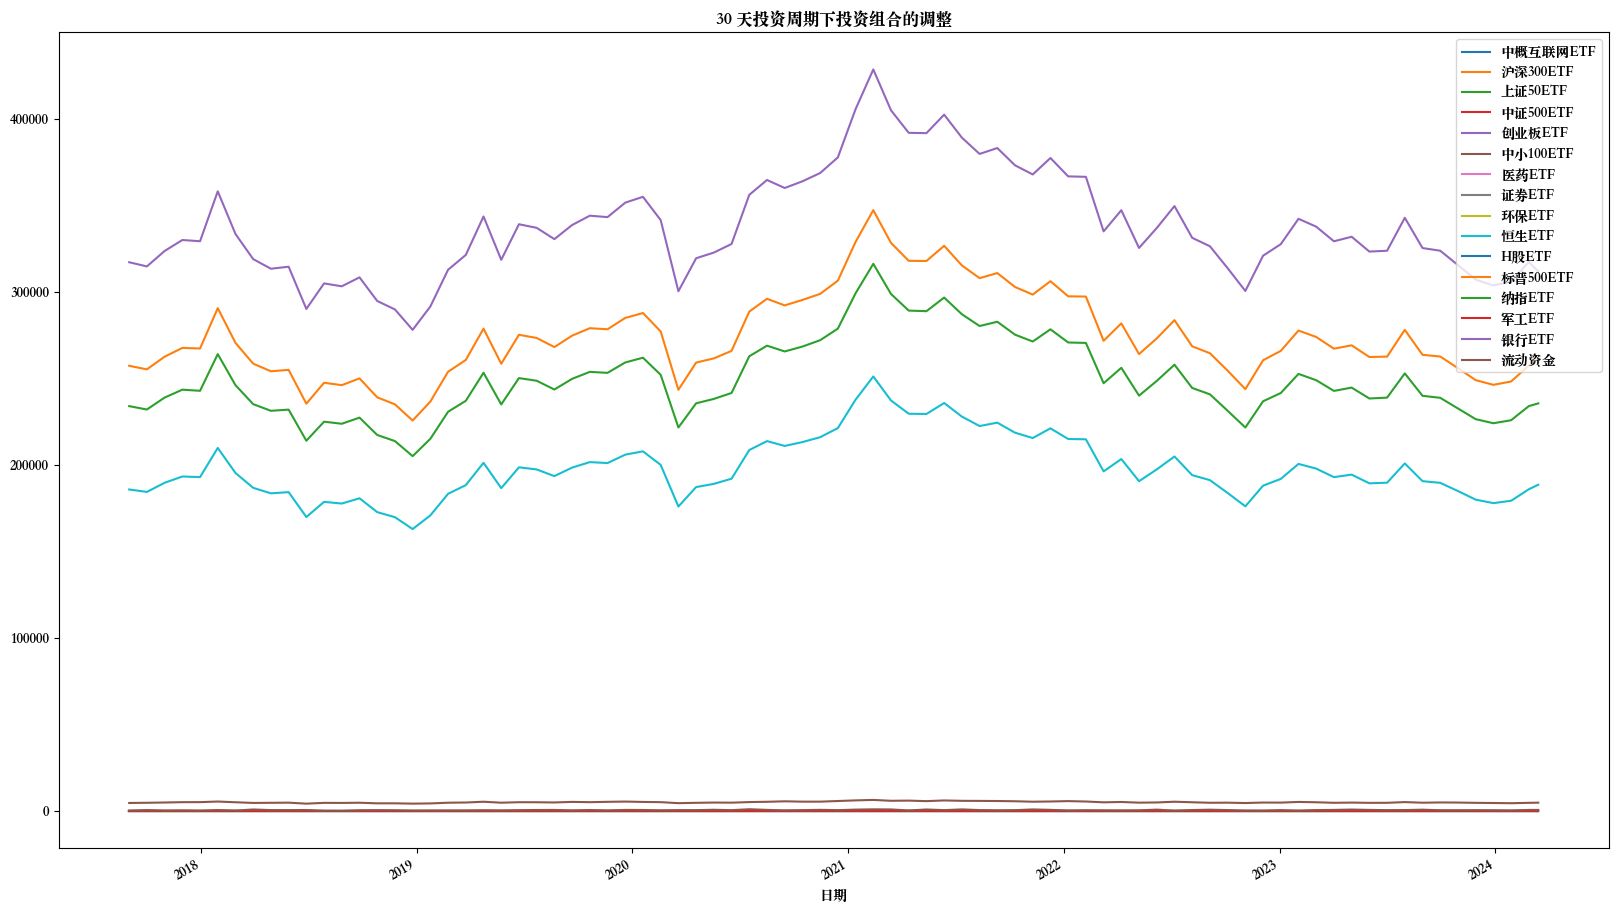

第 2 次随机权重，选取 5 个标的。
                 0
恒生ETF     0.127608
标普500ETF  0.244649
中概互联网ETF  0.280133
医药ETF     0.066375
中小100ETF  0.281235
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金：410.1400000000899
持有量：[323600      0      0      0      0  96600  45900      0      0 125200
      0  72700      0      0      0]
交易费用：3432.0400000000022
最终资产：1064858.92 + 410.1400000000899 = 1065269.06
收益率：0.0652690600000001
日化收益率：0.00%
年化收益率：0.97%


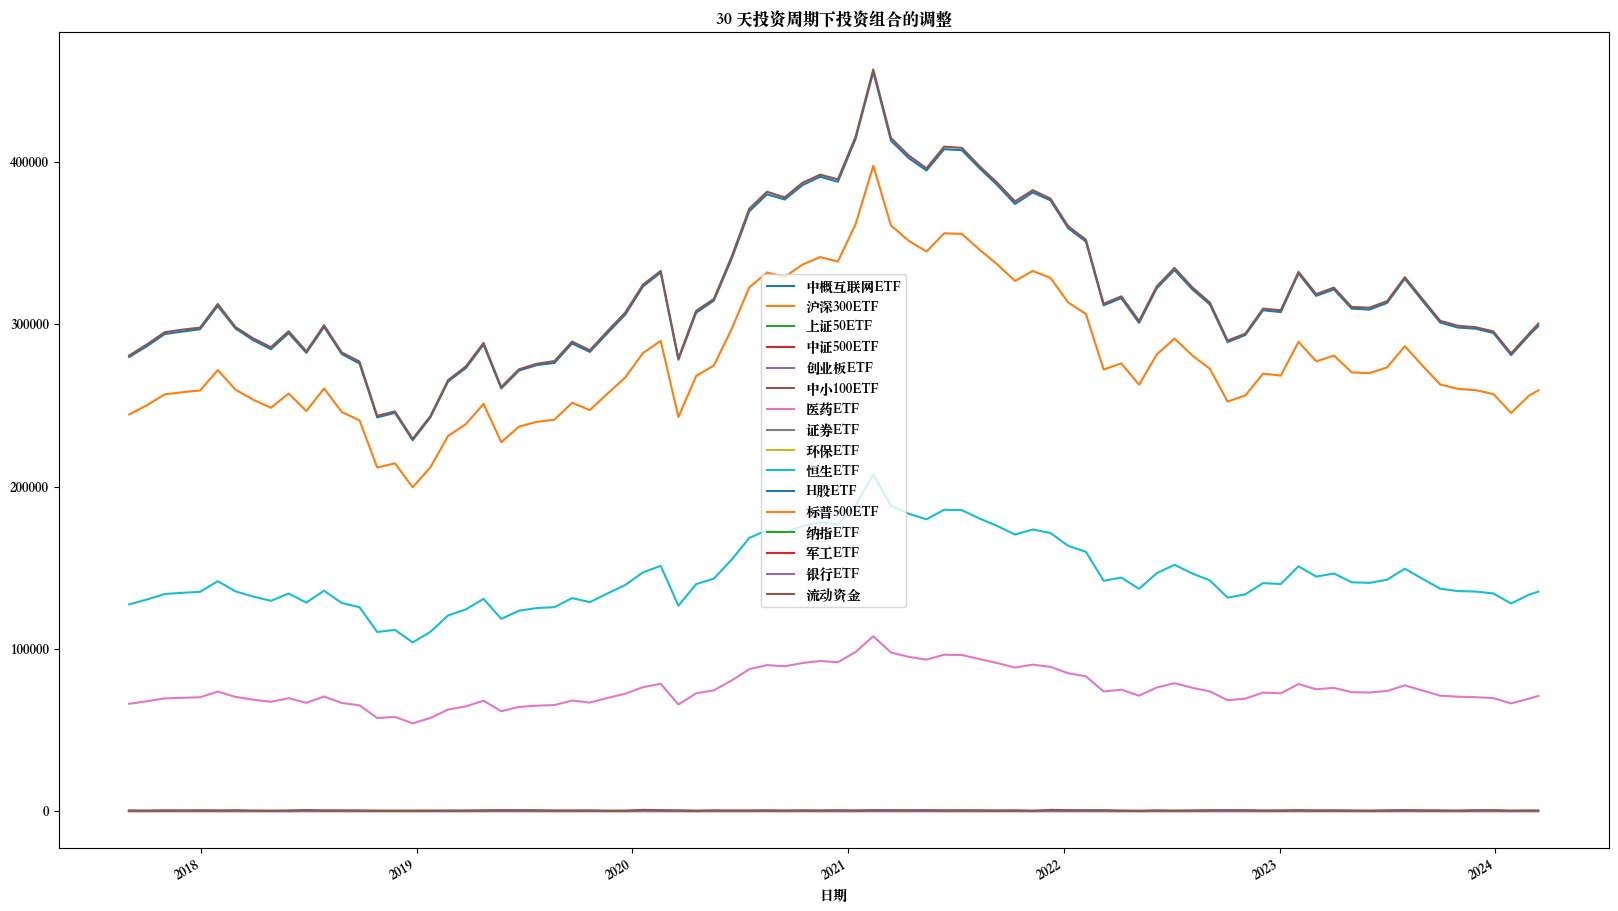

第 3 次随机权重，选取 5 个标的。
                 0
创业板ETF    0.124531
恒生ETF     0.169541
医药ETF     0.239107
中证500ETF  0.257871
标普500ETF  0.208951
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金：545.020000000035
持有量：[     0      0      0 174300  83500      0 185300      0      0 186300
      0  69500      0      0      0]
交易费用：3539.880000000001
最终资产：1195088.0 + 545.020000000035 = 1195633.02
收益率：0.19563302000000005
日化收益率：0.01%
年化收益率：2.77%


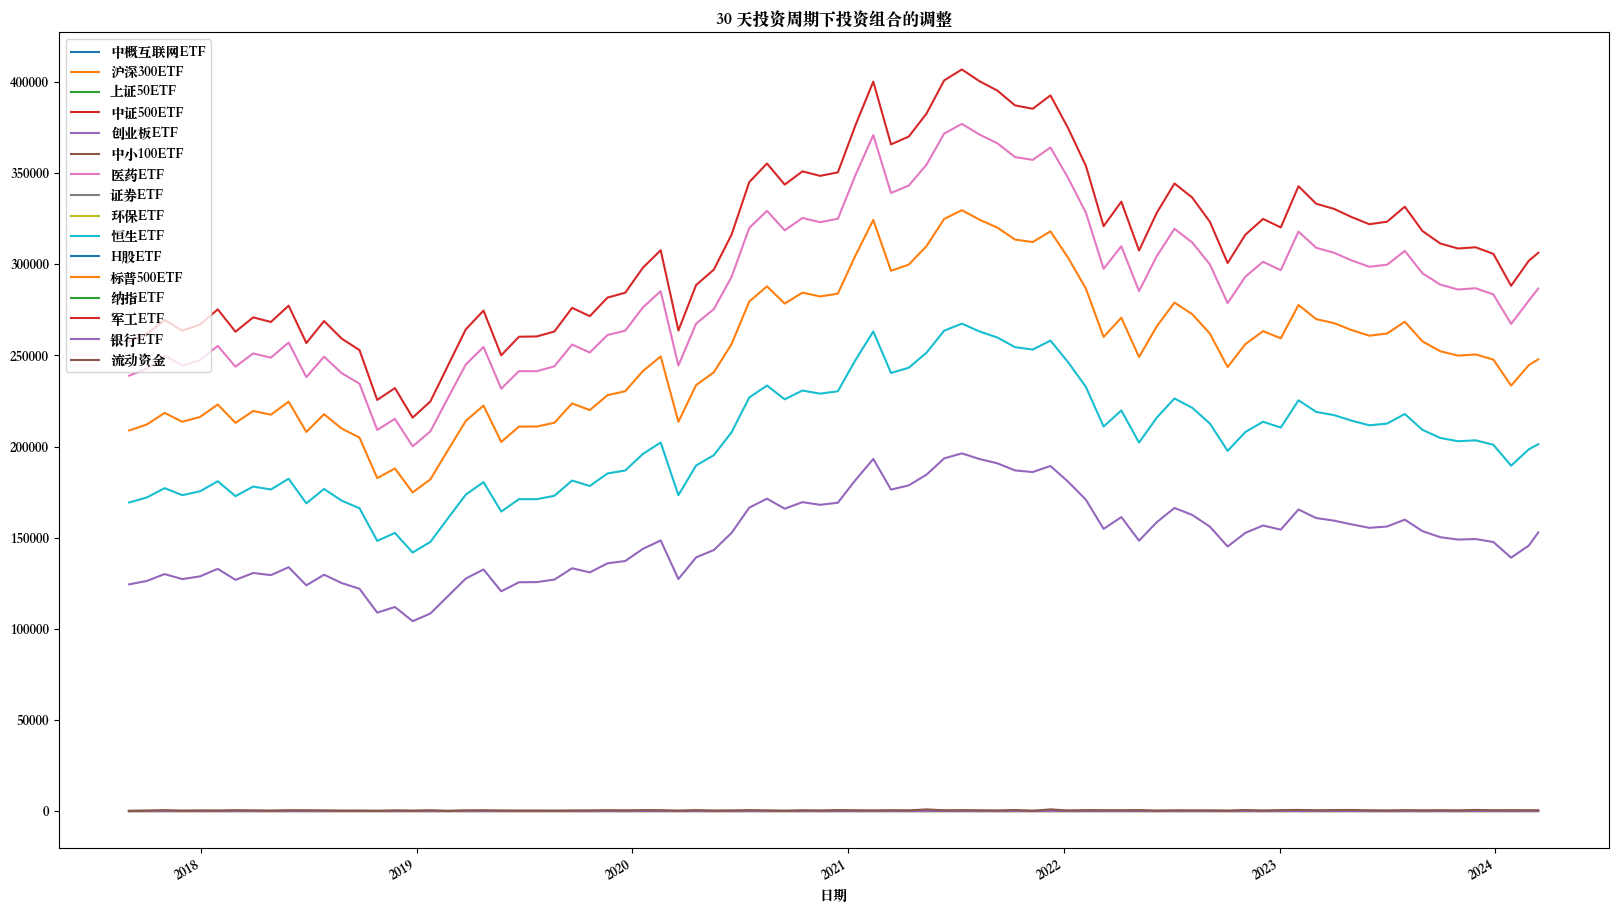

第 4 次随机权重，选取 5 个标的。
                 0
标普500ETF  0.207855
环保ETF     0.235526
沪深300ETF  0.189445
纳指ETF     0.046075
上证50ETF   0.321098
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金：769.8099999999995
持有量：[     0  58700 133400      0      0      0      0      0 332600      0
      0  76000   9000      0      0]
交易费用：3486.4899999999993
最终资产：1315255.3 + 769.8099999999995 = 1316025.11
收益率：0.31602511
日化收益率：0.01%
年化收益率：4.29%


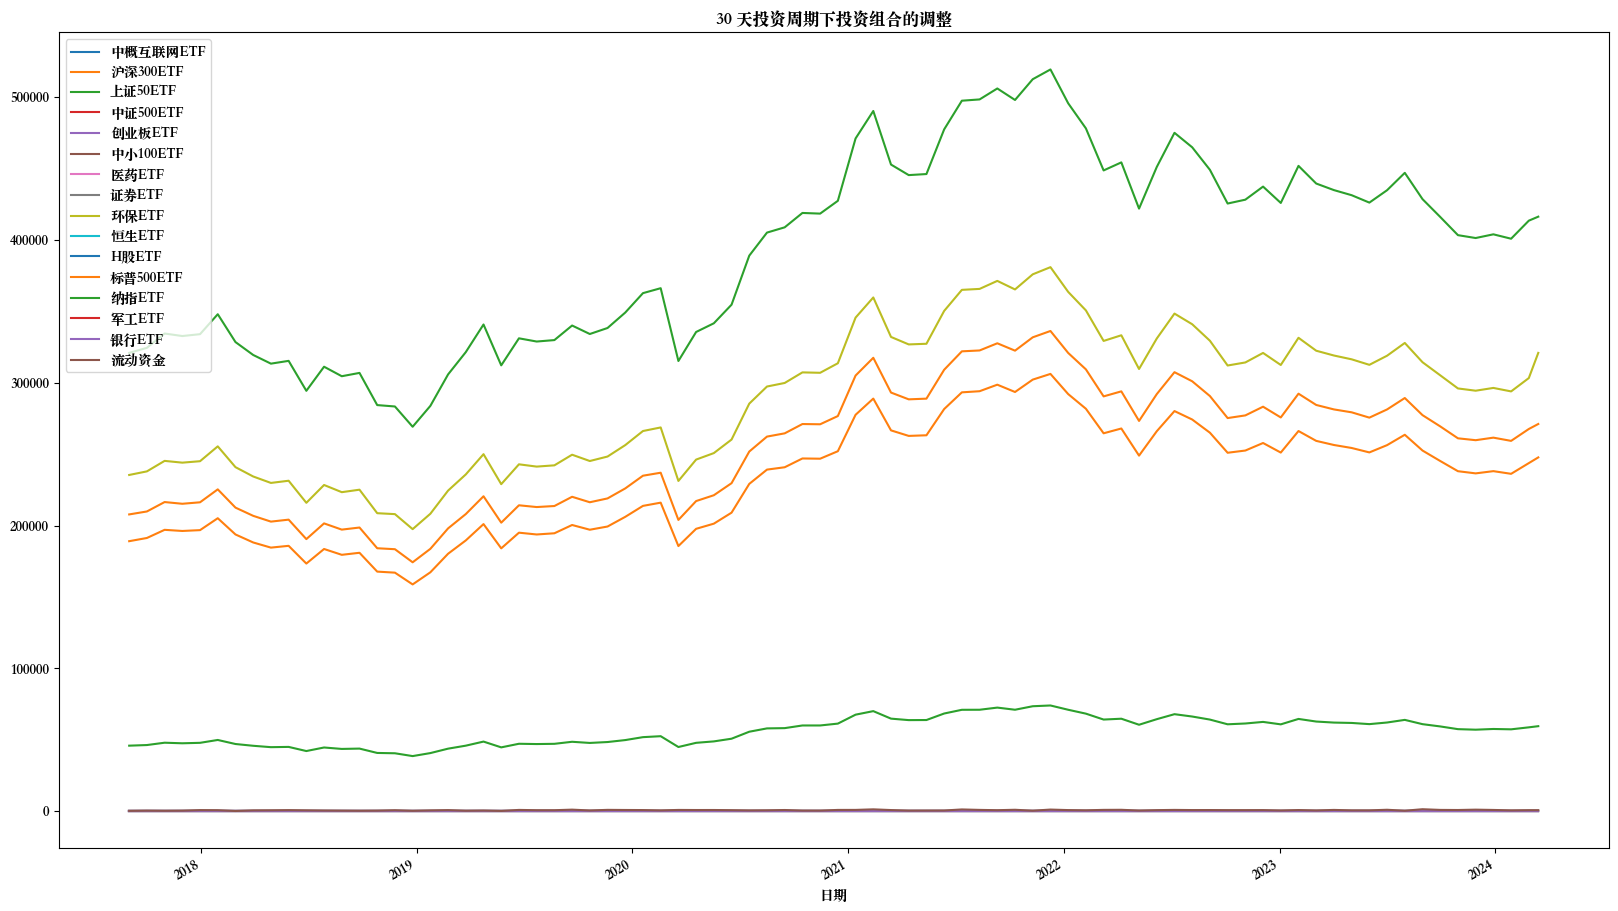

第 5 次随机权重，选取 5 个标的。
               0
H股ETF   0.185098
银行ETF   0.171448
创业板ETF  0.357901
医药ETF   0.155043
纳指ETF   0.130510
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金：662.1399999999376
持有量：[     0      0      0      0 240400      0 120200      0      0      0
 280900      0  23400      0 173000]
交易费用：3638.0000000000014
最终资产：1200070.26 + 662.1399999999376 = 1200732.4
收益率：0.20073239999999992
日化收益率：0.01%
年化收益率：2.84%


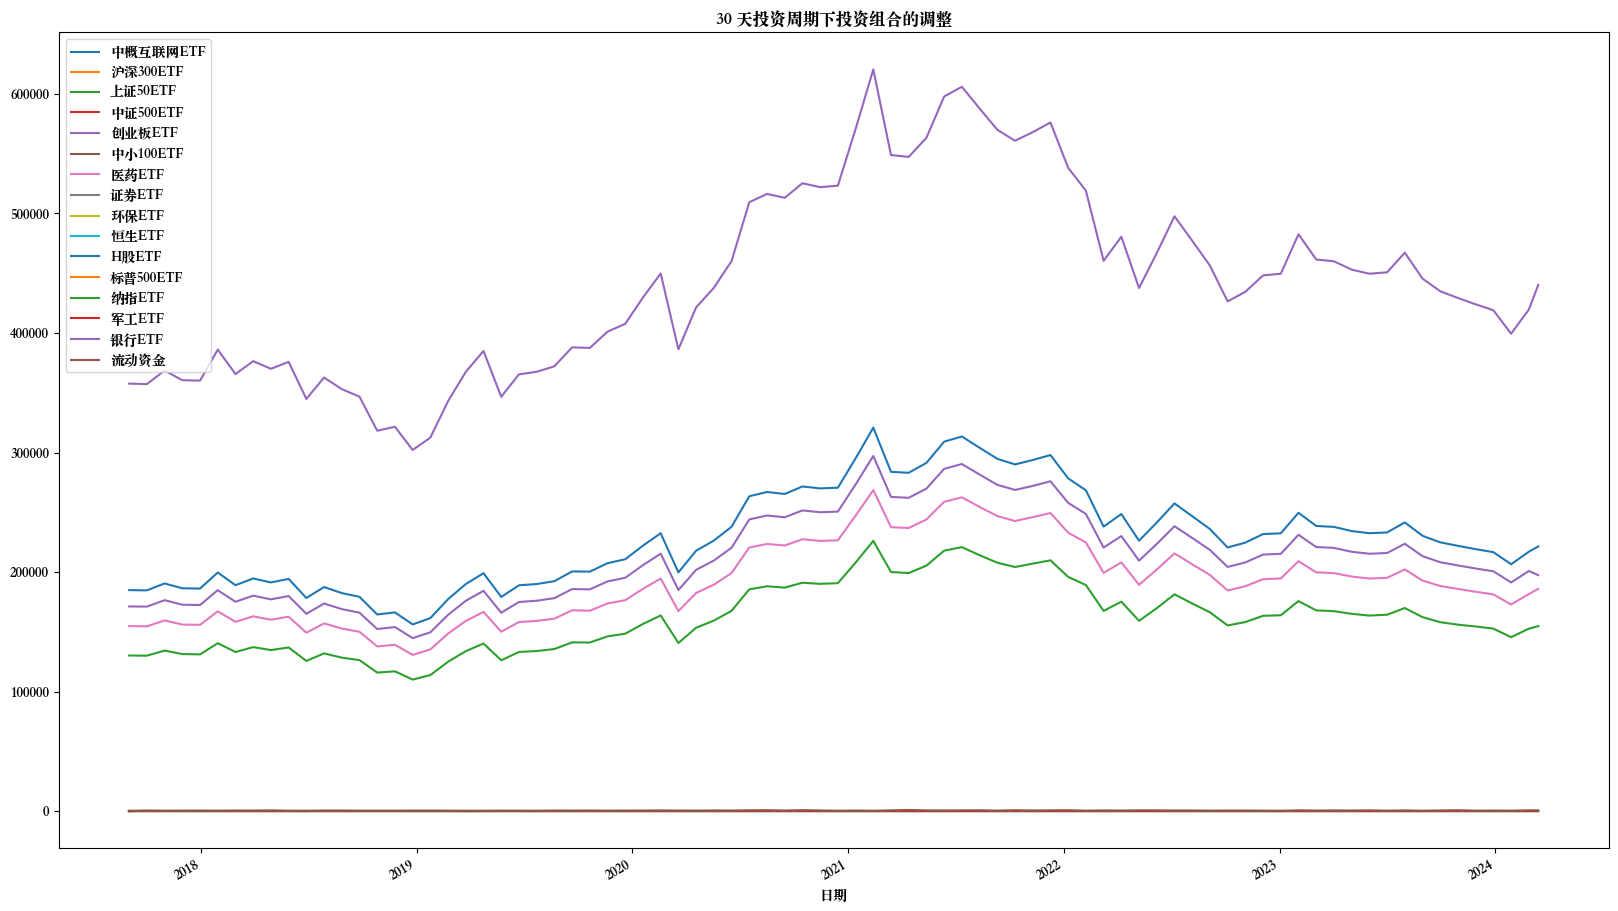

In [227]:
for i in range(5):
    N = 5
    print(f"第 {i+1} 次随机权重，选取 {N} 个标的。")
    w = np.random.choice(len(stockNameCodesExcept), N, replace=False)
    random = np.random.rand(N)
    random /= np.sum(random)

    random_weights = np.zeros(len(stockNameCodesExcept))
    for i, r in zip(w, random):
        random_weights[i] = r

    print(pd.DataFrame([random], columns=[
        stockNameCodesExcept[name][1] for name in w]).T)

    calc_portfolio(datetime.timedelta(days=30),
                   '随机固定权重', lambda _: random_weights, print_weight=False)
    plt.show()

##### 最大化夏普指数

夏普指数是投资组合的预期回报与投资组合风险之间的平衡。

夏普指数越高，投资组合的风险越低，回报越高。

夏普指数的计算公式为：$\mathrm{Sharpe} = \frac{R_p - R_f}{\sigma_p}$。
其中 $R_p$ 是投资组合的预期回报，$R_f$ 是无风险利率，$\sigma_p$ 是投资组合的标准差。

此处将无风险利率设为 0。


In [228]:
def minimal_sharpley(log_returns: pd.DataFrame) -> np.ndarray:
    '''
    为了最大化夏普指数，我们需要找到一个权重向量，使得夏普指数最大化。
    最小化夏普指数的负值。
    '''
    from scipy.optimize import minimize
    # print(log_returns.shape)

    def stats(weights):
        weights = np.array(weights)
        port_returns = np.sum(log_returns.mean()*weights)*252
        port_variance = np.sqrt(
            np.dot(weights.T, np.dot(log_returns.cov()*252, weights)))
        return np.array([port_returns, port_variance, port_returns/port_variance])

    # 最小化夏普指数的负值
    def min_sharpe(weights: np.ndarray) -> float:
        # print(weights.shape)
        return -stats(weights)[2]

    # ETF 数量
    N = log_returns.shape[1]
    # 给定初始权重
    x0 = N*[1./N]

    # 权重（单支基金持仓比例）限制在 0 和 1 之间。
    bnds = tuple((0, 1) for _ in range(N))

    # 权重（基金持仓比例）的总和为 1。
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

    # 优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
    opts = minimize(min_sharpe,
                    x0,
                    method='SLSQP',
                    bounds=bnds,
                    constraints=cons)
    assert opts.success, f"优化失败。{opts.message}"
    return opts.x

总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金 195811.34999999992 不足以购买 73100.0 份 纳指ETF
剩余资金 130039.33999999991 不足以购买 85200.0 份 医药ETF
剩余资金 183835.7699999999 不足以购买 130000.0 份 恒生ETF
剩余资金 194733.1399999999 不足以购买 42100.0 份 纳指ETF
剩余资金：118.45999999990454
持有量：[     0      0      0      0      0      0      0      0      0      0
      0  57500 256300      0      0]
交易费用：8270.349999999999
最终资产：1901048.19 + 118.45999999990454 = 1901166.65
收益率：0.90116665
日化收益率：0.03%
年化收益率：10.33%


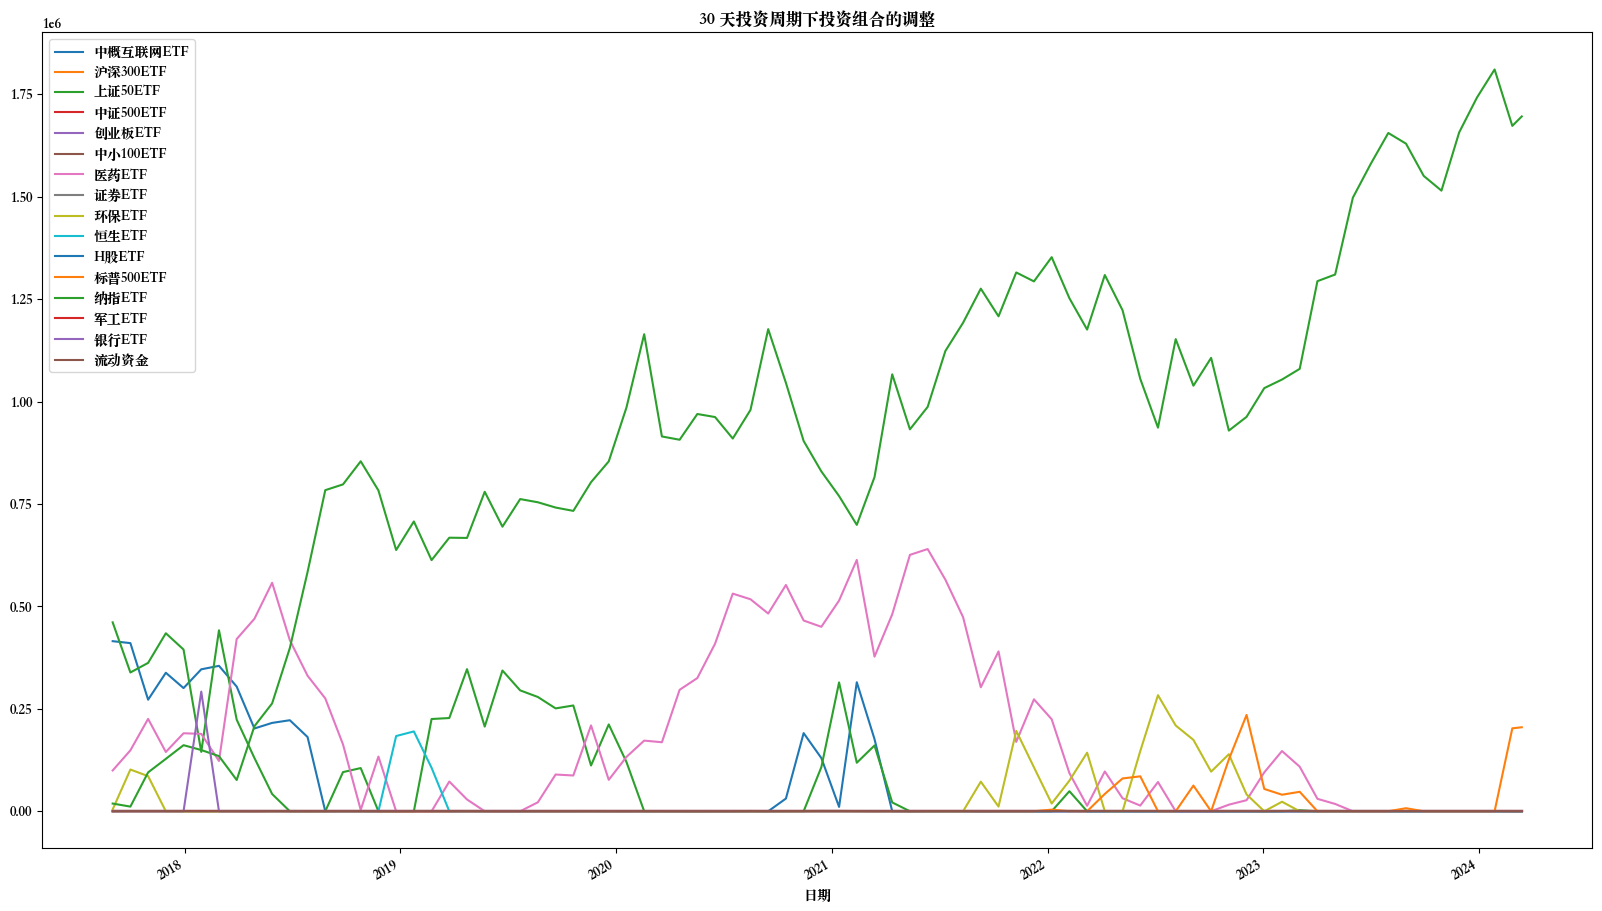

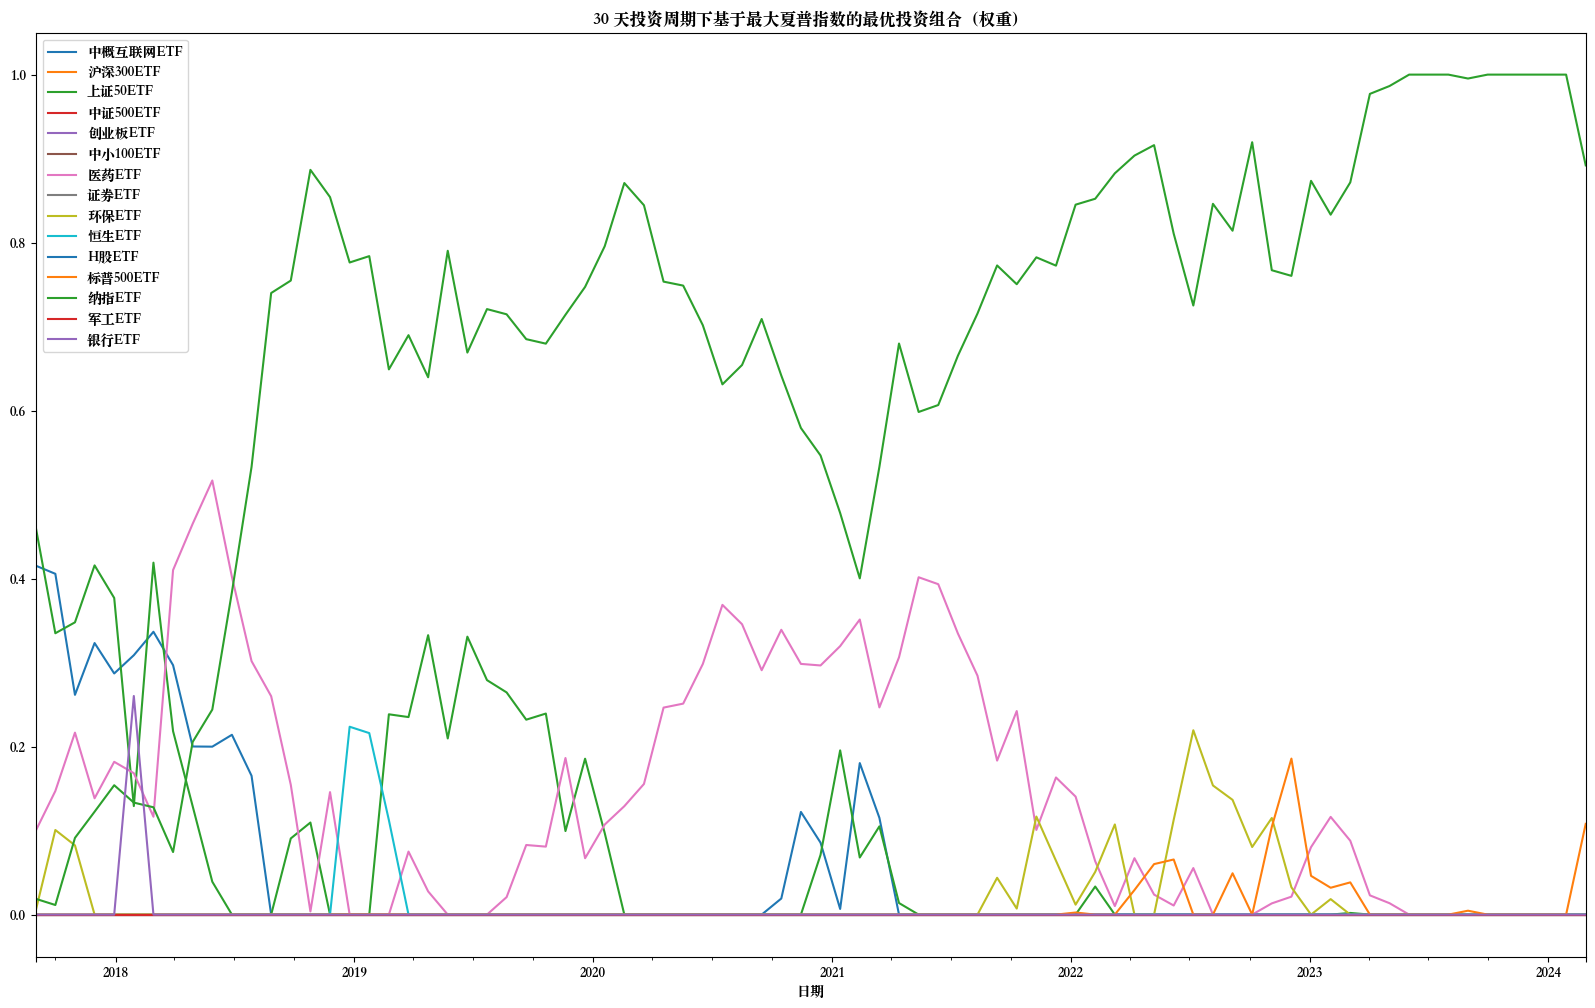

In [229]:
calc_portfolio(datetime.timedelta(days=30), '最大夏普指数', minimal_sharpley)
plt.show()

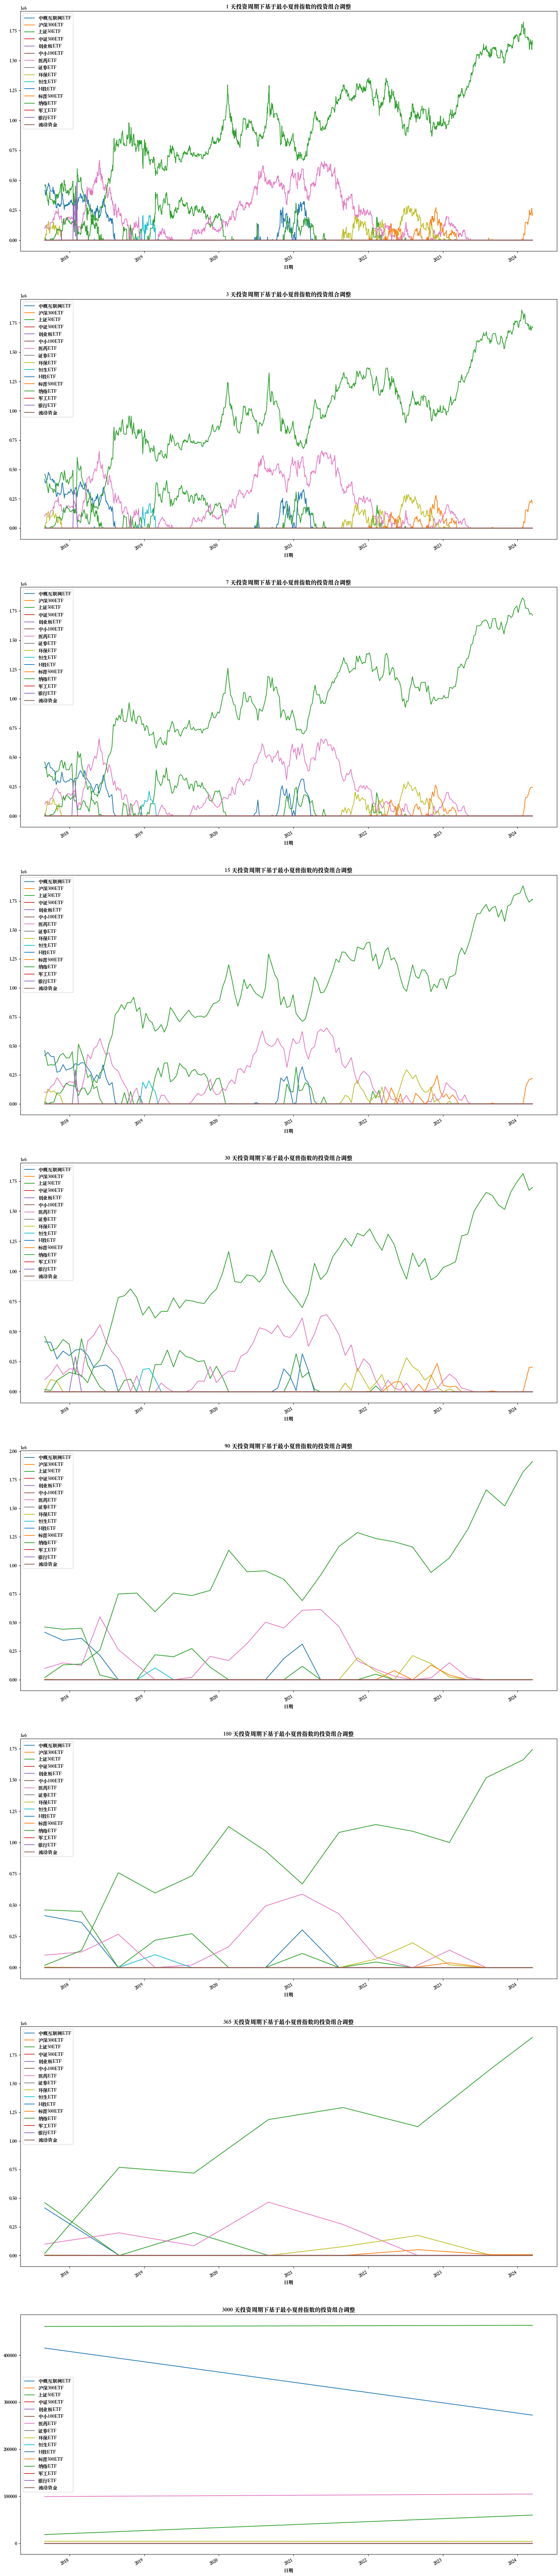

收益率      交易费用
投资周期                         
1 days     0.866888  41296.75
3 days     0.925302  24550.60
7 days     0.956336  15366.55
15 days    0.976236  11293.83
30 days    0.901167   8270.35
90 days    0.909124   4825.84
180 days   0.742997   3810.86
365 days   0.912801   2733.80
3000 days -0.094290    779.48

In [230]:
from joblib import Parallel, delayed

fig = plt.figure(1, figsize=(20, 12*len(deltas)))
axes = fig.subplots(len(deltas), 1)
# axes = [fig.add_subplot(len(deltas), 1, i+1) for i in range(len(deltas))]


def to_df(i: int, step: datetime.timedelta) -> tuple[pd.DataFrame, pd.DataFrame]:
    final, extra, b = calc_portfolio(
        step, '最大夏普指数', minimal_sharpley, silent=True)
    a = pd.DataFrame({"投资周期": [step], "收益率": [final-1], "交易费用": [extra]})
    return a, b


res: list[tuple[pd.DataFrame, pd.DataFrame]]
# res = [to_df(i, delta) for i, delta in enumerate(deltas[-1:])]
res = Parallel(n_jobs=-1)(delayed(to_df)(i, delta)
                          for i, delta in enumerate(deltas))

a, b = zip(*res)
for i, b in enumerate(b):
    b.plot(ax=axes[i], title=f'{deltas[i].days} 天投资周期下基于最小夏普指数的投资组合调整')
plt.show()
t = pd.concat(a)
t.set_index('投资周期', inplace=True)
t

##### PyPortfolioOpt 库的使用


In [231]:
# 使用前几年的价格数据来决定投资组合并不会有太大的意义（之后腾飞的两只 ETF 在此时都平平无奇），
# 但是可以用来展示如何使用 PyPortfolioOpt 这个库。
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# https://pyportfolioopt.readthedocs.io/en/latest/

pre = datetime.datetime(2015, 9, 1)
allStockDailyPre = Preprocess(pre, start)

stockNameCodesPre = stockNameCodes.copy()
# 房地产 ETF 尚未上市
stockNameCodesPre.remove(("512200", "房地产ETF"))
stockNameCodesPre.remove(("512980", "传媒ETF"))
# 与前面的 prices 相似，但没有除以首日的价格
df = pd.concat([i.iloc[:, 2]for _, i in allStockDailyPre.items()],
               keys=[i[1] for i in stockNameCodesPre], axis=1)
# df = pd.read_csv("../PyPortfolioOpt/tests/resources/stock_prices.csv",
#                  parse_dates=True, index_col="date")

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
w = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

print(ef.clean_weights())

使用已有数据(2014-2017)
房地产ETF(512200)读取失败!
传媒ETF(512980)读取失败!
Expected annual return: 26.6%
Annual volatility: 5.3%
Sharpe Ratio: 4.68
OrderedDict([('中概互联网ETF', 0.18051), ('沪深300ETF', 0.0), ('上证50ETF', 0.0), ('中证500ETF', 0.0), ('创业板ETF', 0.0), ('中小100ETF', 0.0), ('医药ETF', 0.00623), ('证券ETF', 0.0), ('环保ETF', 0.0), ('恒生ETF', 0.0), ('H股ETF', 0.0), ('标普500ETF', 0.0), ('纳指ETF', 0.0), ('军工ETF', 0.0), ('银行ETF', 0.0), ('国债ETF', 0.18784), ('十年国债ETF', 0.62542)])


/opt/homebrew/anaconda3/lib/python3.11/site-packages/pypfopt/risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


In [232]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(w, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio(reinvest=True, verbose=True)
print(allocation)

Funds remaining: 19.73
中概互联网ETF: allocated 0.181, desired 0.181
沪深300ETF: allocated 0.001, desired 0.000
上证50ETF: allocated 0.000, desired 0.000
中证500ETF: allocated 0.000, desired 0.000
创业板ETF: allocated 0.000, desired 0.000
中小100ETF: allocated 0.001, desired 0.000
医药ETF: allocated 0.007, desired 0.006
证券ETF: allocated 0.000, desired 0.000
环保ETF: allocated 0.000, desired 0.000
恒生ETF: allocated 0.001, desired 0.000
H股ETF: allocated 0.000, desired 0.000
标普500ETF: allocated 0.000, desired 0.000
纳指ETF: allocated 0.000, desired 0.000
军工ETF: allocated 0.000, desired 0.000
银行ETF: allocated 0.000, desired 0.000
国债ETF: allocated 0.184, desired 0.188
十年国债ETF: allocated 0.625, desired 0.625
Allocation has RMSE: 0.001
{'中概互联网ETF': 2566, '沪深300ETF': 3, '上证50ETF': 1, '中小100ETF': 7, '医药ETF': 90, '证券ETF': 1, '环保ETF': 5, '恒生ETF': 19, '纳指ETF': 3, '军工ETF': 1, '银行ETF': 1, '国债ETF': 33, '十年国债ETF': 125}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
